In [1]:
# # magic
# %load_ext autoreload
# %autoreload 2 
# #any changes to the function files will be updated on every run
# #%pdb 1 
# #where code fails, stops at that breakpoint and allows to examine potential error
# %matplotlib inline

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math
#import numdifftools as nd
import pandas as pd
#import pymc3 as pm

from tqdm import tqdm
from sklearn import preprocessing
from numpy.linalg import multi_dot
import scipy
from scipy import stats
from scipy.stats import invgamma
from scipy.special import gamma
from scipy.special import digamma
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import levy_stable
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import sklearn.mixture

c:\Users\nngu8343\AppData\Local\miniconda3\envs\vbsl\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
np.random.seed(6898)

In [4]:
from f_mean_adjust_ss_wasserstein_toad import (toad, compute_summaries, compute_summaries_stacked, mean_adjustment_summary_statistics)

In [5]:
def my_inv(x):
    return np.linalg.inv(x + (np.eye(x.shape[0]) * 1e-7))

## LOAD DATASET

In [6]:
true_theta = np.array([1.7, 35.0, 0.6])

In [7]:
actual_data = toad(true_theta[0], true_theta[1], true_theta[2])
actual_data

array([[[   0.        ],
        [   0.        ],
        [   0.        ],
        ...,
        [   0.        ],
        [   0.        ],
        [   0.        ]],

       [[   0.        ],
        [   0.        ],
        [   0.        ],
        ...,
        [  34.34072192],
        [-114.90929485],
        [   0.        ]],

       [[   0.        ],
        [   0.        ],
        [  14.77626633],
        ...,
        [   0.        ],
        [   0.        ],
        [   0.        ]],

       ...,

       [[   1.44536367],
        [   0.95211074],
        [   0.        ],
        ...,
        [ 175.97525327],
        [  11.52387449],
        [-160.28106   ]],

       [[ -22.59101752],
        [ -51.60382165],
        [ -25.62044882],
        ...,
        [   0.        ],
        [   0.        ],
        [ -54.30328451]],

       [[ -46.94945853],
        [  -4.38496736],
        [   0.        ],
        ...,
        [ 175.97525327],
        [ -34.79864139],
        [   0.        ]]

In [8]:
lags = [1, 2, 4, 8]
num_coeffs = 3
num_latent = 12
num_datasets = 200
n_samples = 200
gamma_samples = 20

In [9]:
actual_summary_statistics = compute_summaries_stacked(actual_data, lags)[0]
actual_summary_statistics

array([6.9246124 , 3.66996993, 6.30071171, 6.7178047 , 3.91656951,
       6.31433913, 6.66185474, 4.03792021, 6.47012367, 6.50578406,
       4.0408775 , 6.33987272])

In [10]:
from multiprocessing import Pool
from functools import partial
pool = Pool(12)

## Training Wasserstein Gaussianing

In [11]:
wass_num_datasets = 3000
wass_n_samples = 30
maxG = 4

In [12]:
# Generating data to train the transform
wass_datasets = toad(true_theta[0], true_theta[1], true_theta[2],batch_size=wass_num_datasets)
wass_n_summary_statistics = np.array([compute_summaries_stacked(wass_datasets[:,:,i], lags)[0] for i in range(wass_num_datasets)])

In [13]:
# Divide the synthetic data to train, test, val
wass_train_summary_statistics = wass_n_summary_statistics[:int(wass_num_datasets/3),:]
wass_val_summary_statistics = wass_n_summary_statistics[int(wass_num_datasets/3):int(wass_num_datasets * 2/3),:]
wass_test_summary_statistics = wass_n_summary_statistics[int(wass_num_datasets * 2/3):wass_num_datasets,:]

original_train_summary_statistics = wass_train_summary_statistics
original_test_summary_statistics = wass_test_summary_statistics

In [14]:
def mixture_model_fit(data, maxG):
    bic_values = []
    for g in np.arange(1, maxG+1):
        mixture_obj = sklearn.mixture.GaussianMixture(n_components = g, reg_covar = 1e-5).fit(data)
        bic_values.append(mixture_obj.bic(data))
    bestG = np.argmin(bic_values) + 1
    best_mixture_obj = sklearn.mixture.GaussianMixture(n_components = bestG, reg_covar = 1e-5).fit(data)
    return best_mixture_obj, bestG

In [15]:
def grad_log_density_mixture(data, mixture_obj):
    mean_mixture_obj = mixture_obj.means_
    sigma_mixture_obj = mixture_obj.covariances_
    weights_mixture_obj = mixture_obj.weights_
    bestG = len(weights_mixture_obj)

    loglh_all_mixture = []
    grad_loglh_all_mixture = []
    for k in range(bestG):
        mean_kth_mixture = mean_mixture_obj[k,:] #1 x g
        sigma_kth_mixture = sigma_mixture_obj[k,:] # g x g
        weight_kth_mixture = weights_mixture_obj[k] 
        diff_mean_kth_mixture = data - mean_kth_mixture #99 x g aux
        loglh_all_mixture.append(np.log(weight_kth_mixture) - num_coeffs/2 * np.log(2 * np.pi)-1/2 * np.log(np.linalg.det(sigma_kth_mixture)) - 1/2 * np.diag(diff_mean_kth_mixture @ my_inv(sigma_kth_mixture) @ diff_mean_kth_mixture.T)) # 99x99 -> diag:1x99->gx99 lw
        grad_loglh_all_mixture.append(-diff_mean_kth_mixture @ my_inv(sigma_kth_mixture)) #M =99 x dim of ss =4

    max_llh_all_data = np.max(loglh_all_mixture, axis = 0) # 99 x 1
    aux_llh_all_data = loglh_all_mixture - max_llh_all_data #g x 99
    w_all_data = np.exp(aux_llh_all_data) / np.sum(np.exp(aux_llh_all_data), axis = 0) #g x 99
    log_f = np.log(np.sum(np.exp(aux_llh_all_data), axis = 0)) + max_llh_all_data #99 x 1

    grad_log_f = 0
    for k in range(bestG):    
        grad_log_f = grad_log_f + np.tile(np.reshape(w_all_data[k,:], (len(data),1)),(1,len(actual_summary_statistics))) * grad_loglh_all_mixture[k] #data x num_coeff
    return log_f, grad_log_f

In [16]:
# At current particles, fit mixture normal
mixture_obj, bestG = mixture_model_fit(original_train_summary_statistics, maxG)

In [17]:
# Start training

# Hyperparams
patience_max = 5
patience = 0 
stop = 5000
eps = 0.005
t_w = 10

# Initialize empty chain
mixture_obj_seq = [0] * (stop+1)
bestG_seq = [0] * (stop+1)
mixture_obj_seq[0] = mixture_obj
bestG_seq[0] = bestG
lb = []
LB_Smoothed = []

In [18]:
for t in range(stop):
    stepsize = eps

    train_grad_log_f = grad_log_density_mixture(wass_train_summary_statistics, mixture_obj)[1]
    v = -wass_train_summary_statistics-train_grad_log_f
    wass_train_summary_statistics = wass_train_summary_statistics + stepsize * v

    val_grad_log_f = grad_log_density_mixture(wass_val_summary_statistics, mixture_obj)[1]
    val_log_f = grad_log_density_mixture(wass_val_summary_statistics, mixture_obj)[0]
    v = -wass_val_summary_statistics-val_grad_log_f
    wass_val_summary_statistics = wass_val_summary_statistics + stepsize * v
    h_vector = -1/2 * np.diag(wass_val_summary_statistics @ wass_val_summary_statistics.T) - val_log_f 

    test_grad_log_f = grad_log_density_mixture(wass_test_summary_statistics, mixture_obj)[1]
    v = -wass_test_summary_statistics-test_grad_log_f
    wass_test_summary_statistics = wass_test_summary_statistics + stepsize * v

    # Update new mixture model
    mixture_obj = mixture_model_fit(wass_train_summary_statistics, maxG)[0]
    bestG = mixture_model_fit(wass_train_summary_statistics, maxG)[1]

    if min(mixture_obj.weights_) < 0.005:
        mixture_obj = mixture_model_fit(wass_train_summary_statistics, bestG - 1)[0]

    mixture_obj_seq[t+1] = mixture_obj
    bestG_seq[t+1] = bestG

    lb.append(np.mean(h_vector))

    if t < t_w:
        print('LB', np.mean(h_vector))

    if t >= t_w:
        LB_smoothed = np.mean(lb[t - t_w + 1 : t])
        print('LB Smoothed', LB_smoothed)
        LB_Smoothed.append(LB_smoothed)
        if LB_smoothed >= np.max(LB_Smoothed):
            patience = 0
        else:
            patience += 1
            if patience > patience_max:
                print("Stop at", t)
                break
    if t > t_w and abs(LB_Smoothed[t - t_w] - LB_Smoothed[t - t_w - 1]) < 10e-02:
        print("Stop threshold at", t)
        break

LB -260.0169894294822
LB -236.26081306264095
LB -232.86799153900733
LB -229.75385056258077
LB -226.53576285748562
LB -223.76179540739417
LB -221.0808440747001
LB -218.4771731392999
LB -215.93986018976307
LB -213.46092949082185
LB Smoothed -224.23766892485486
LB Smoothed -221.4347264256134
LB Smoothed -218.74443111002412
LB Smoothed -216.1406866429616
LB Smoothed -213.63956673295678
LB Smoothed -211.1959625792855
LB Smoothed -208.8035353698092
LB Smoothed -206.45748809178338
LB Smoothed -204.15405857640786
LB Smoothed -201.89021459161938
LB Smoothed -199.66345832415985
LB Smoothed -197.4716948424683
LB Smoothed -195.3131402199443
LB Smoothed -193.1862553874285
LB Smoothed -191.0896973020017
LB Smoothed -189.0222821296242
LB Smoothed -186.982956979051
LB Smoothed -184.9707778573322
LB Smoothed -182.98489223878377
LB Smoothed -181.02452511246585
LB Smoothed -179.0889676913926
LB Smoothed -177.17756818546252
LB Smoothed -175.28972419348847
LB Smoothed -173.4248763791519
LB Smoothed -171.58

<Axes: title={'center': 'Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

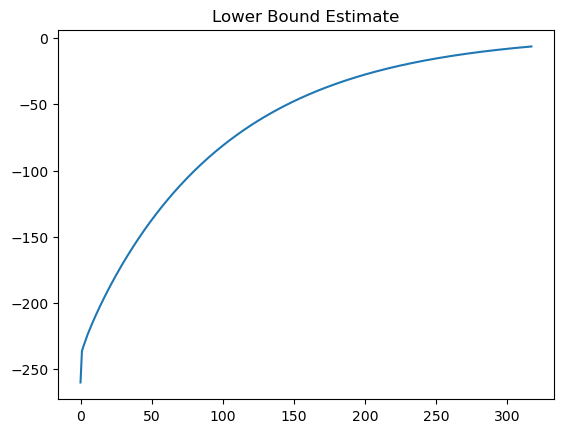

In [19]:
wass_lb_df = pd.DataFrame(np.array(lb))
plt.figure()
wass_lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<Axes: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

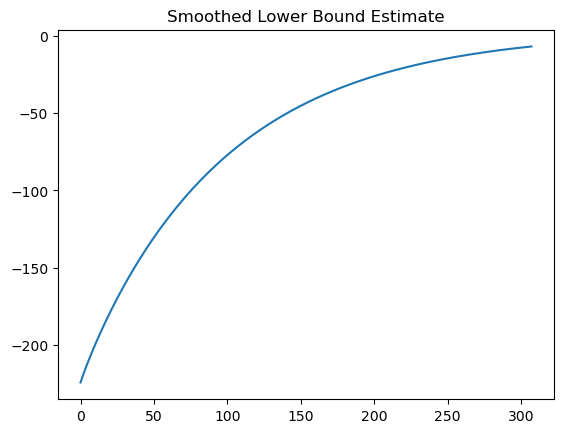

In [20]:
wass_smoothed_lb_df = pd.DataFrame(np.array(LB_Smoothed))
plt.figure()
wass_smoothed_lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

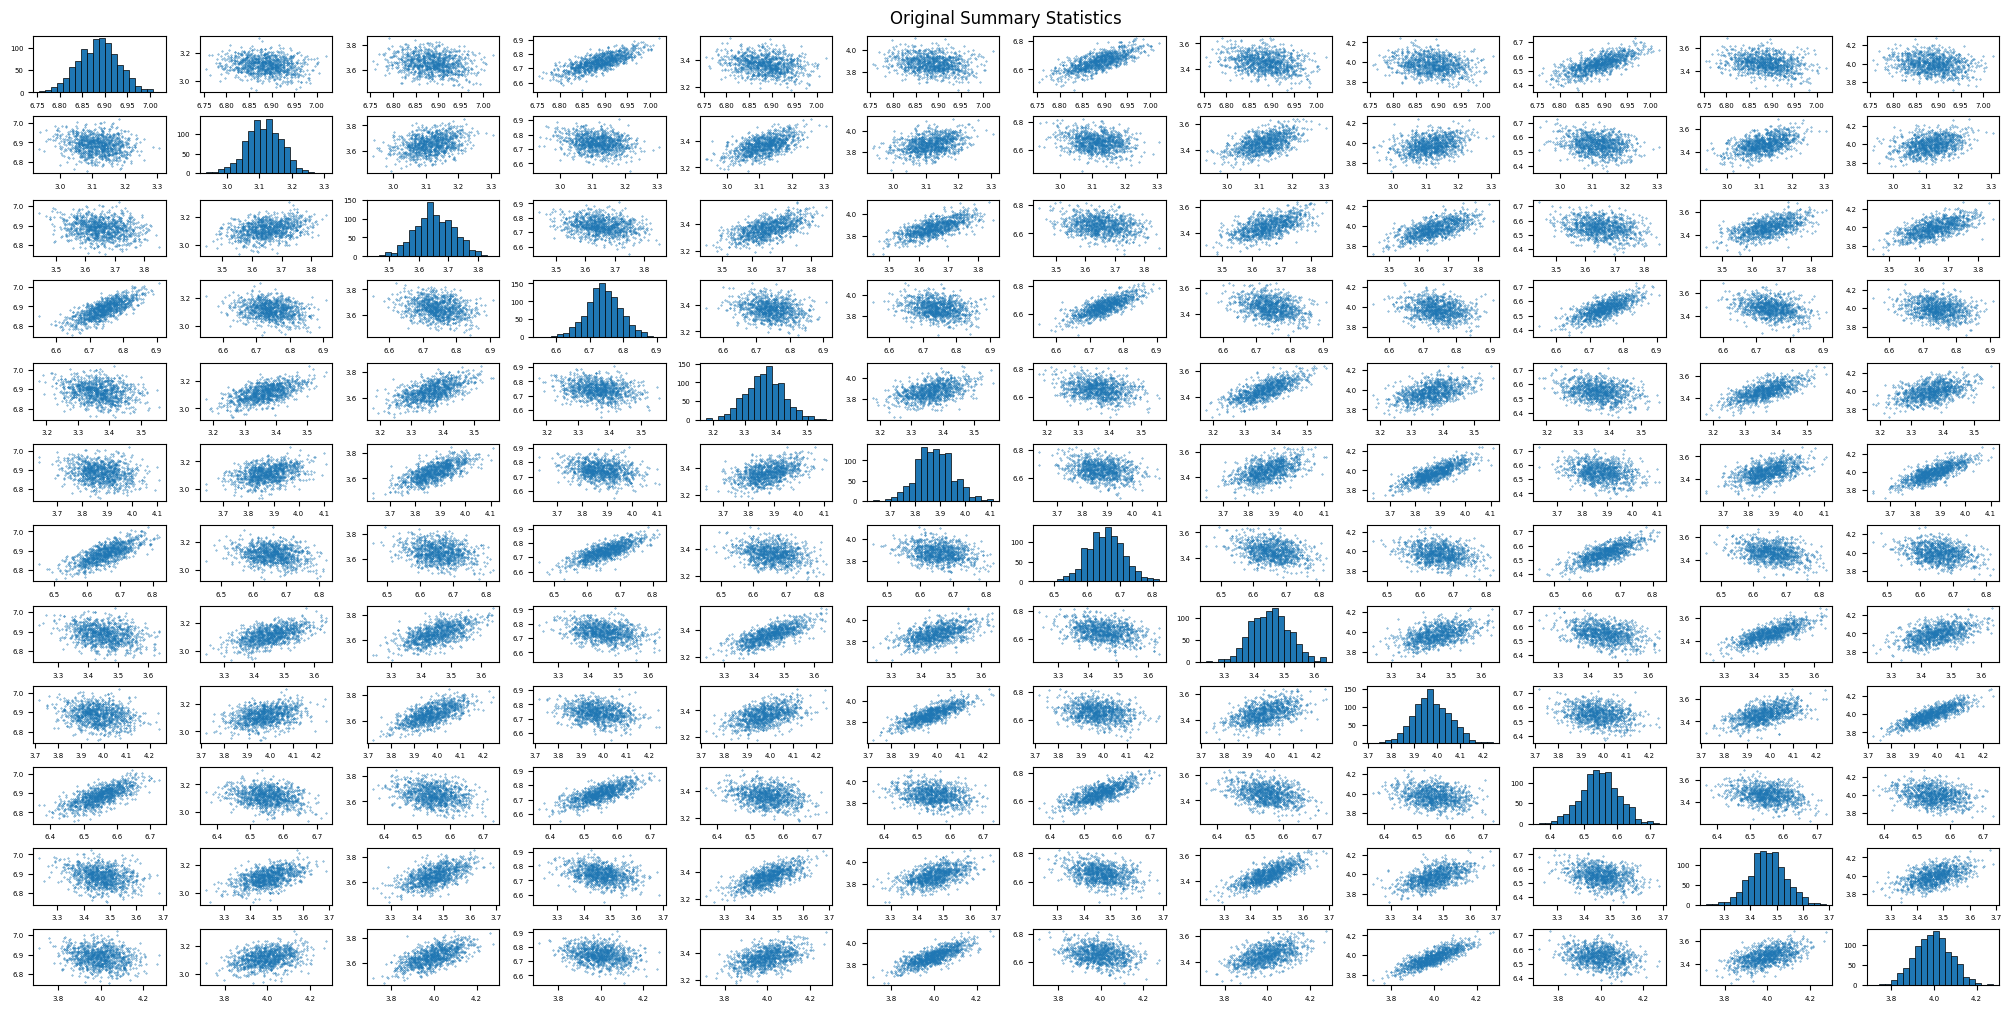

In [30]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(12, 12, figsize=(20,10), constrained_layout=True)

# For Sine Function
for x in range(12):
    for y in range(12):
        if x != y:
            axis[x, y].scatter(original_train_summary_statistics[:,x], original_train_summary_statistics[:,y], s = 0.1)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)
        else:
            axis[x, y].hist(original_train_summary_statistics[:,x], bins = 20, edgecolor='black', linewidth=0.5)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# Combine all the operations and display
figure.suptitle('Original Summary Statistics')
plt.show()


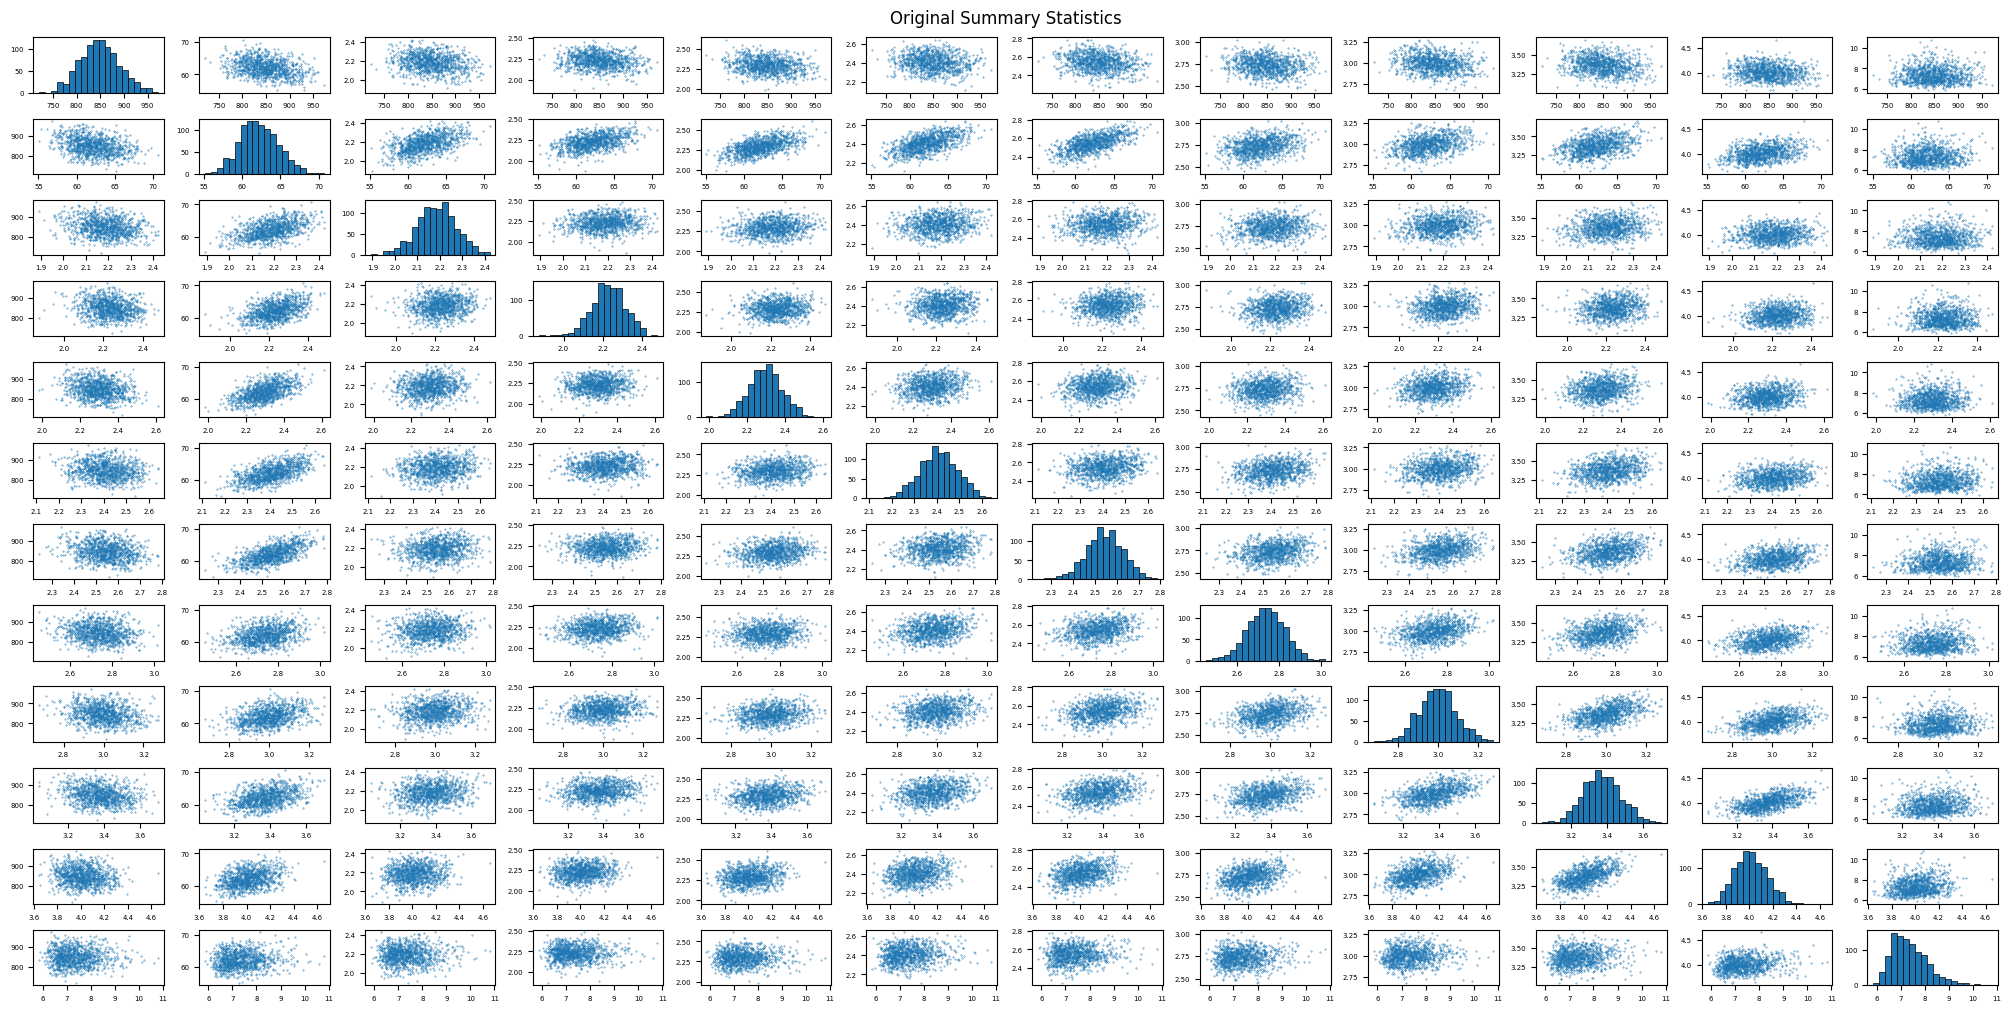

In [79]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(12, 12, figsize=(20,10), constrained_layout=True)

# For Sine Function
for x in range(12):
    for y in range(12):
        if x != y:
            axis[x, y].scatter(original_train_summary_statistics[:,x+12], original_train_summary_statistics[:,y+12], s = 0.1)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)
        else:
            axis[x, y].hist(original_train_summary_statistics[:,x+12], bins = 20, edgecolor='black', linewidth=0.5)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# Combine all the operations and display
figure.suptitle('Original Summary Statistics')
plt.show()

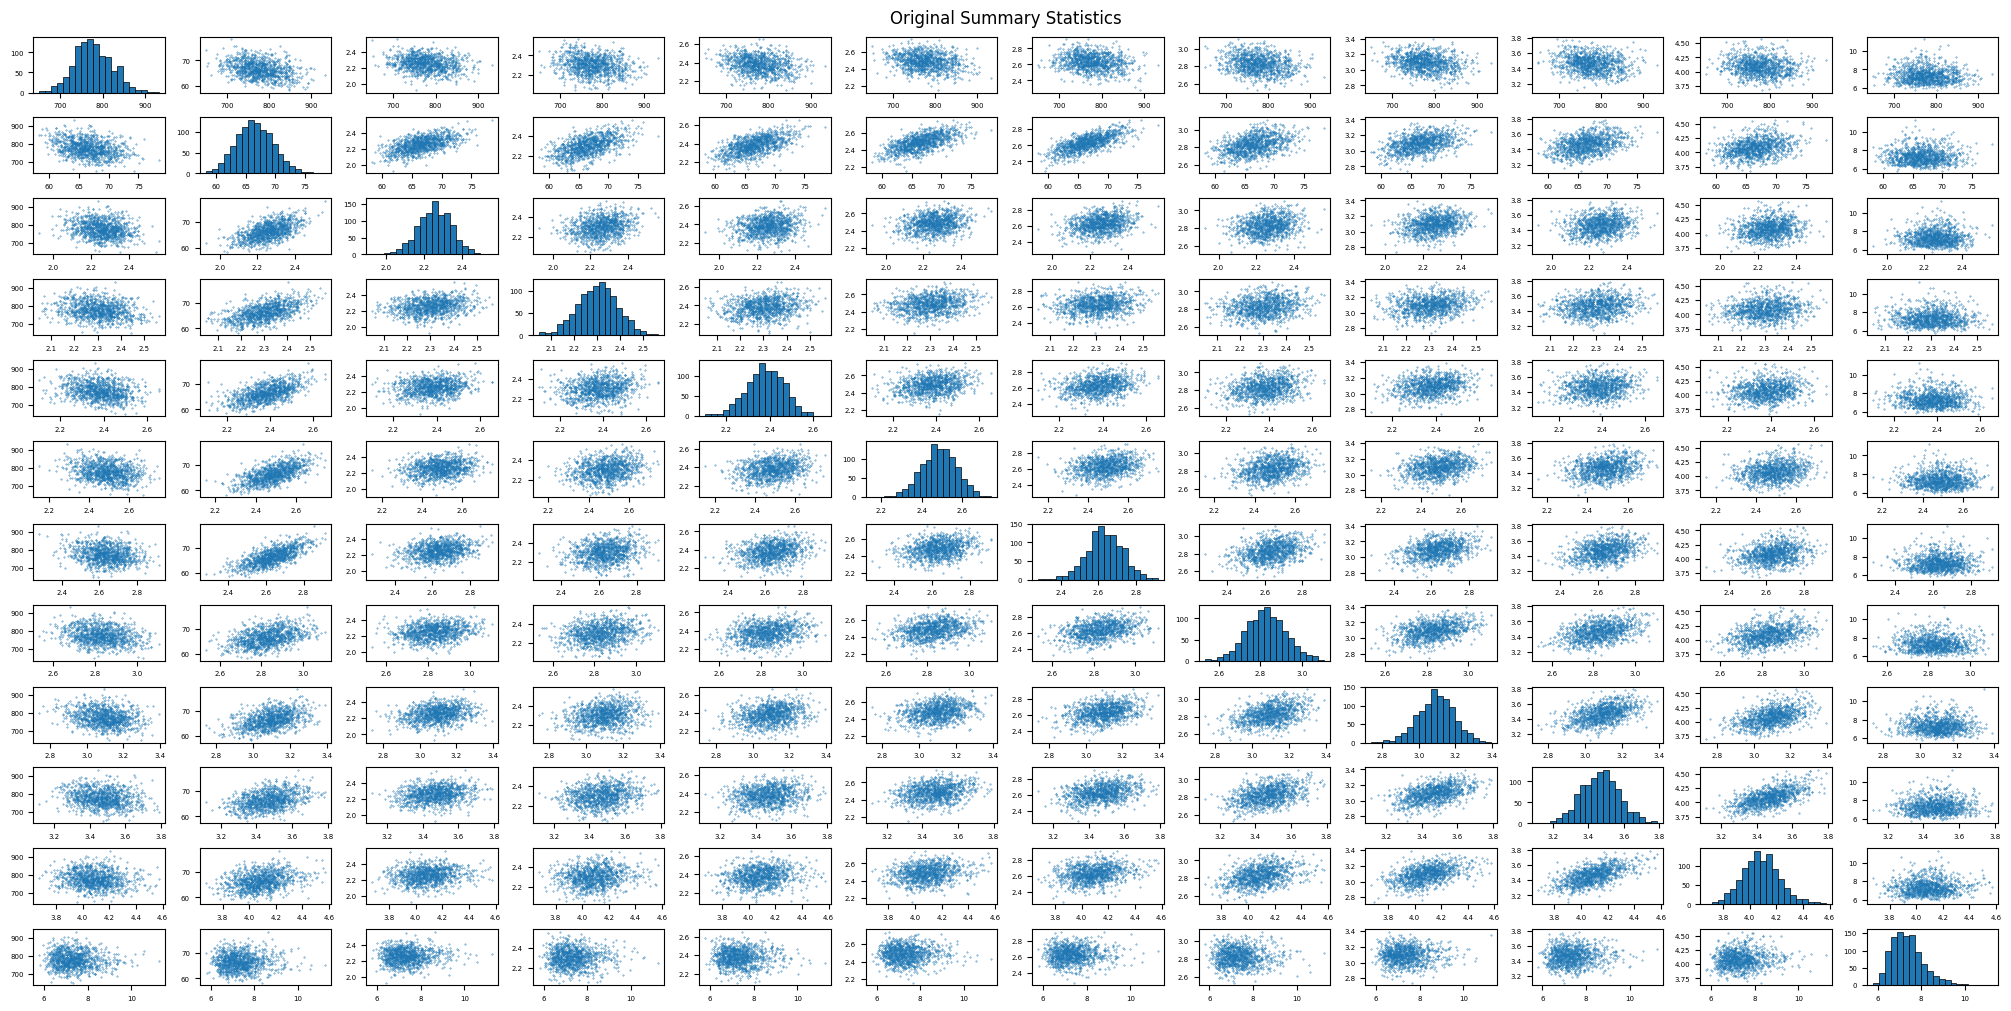

In [68]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(12, 12, figsize=(20,10), constrained_layout=True)

# For Sine Function
for x in range(12):
    for y in range(12):
        if x != y:
            axis[x, y].scatter(original_train_summary_statistics[:,x+24], original_train_summary_statistics[:,y+24], s = 0.1)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)
        else:
            axis[x, y].hist(original_train_summary_statistics[:,x+24], bins = 20, edgecolor='black', linewidth=0.5)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# Combine all the operations and display
figure.suptitle('Original Summary Statistics')
plt.show()

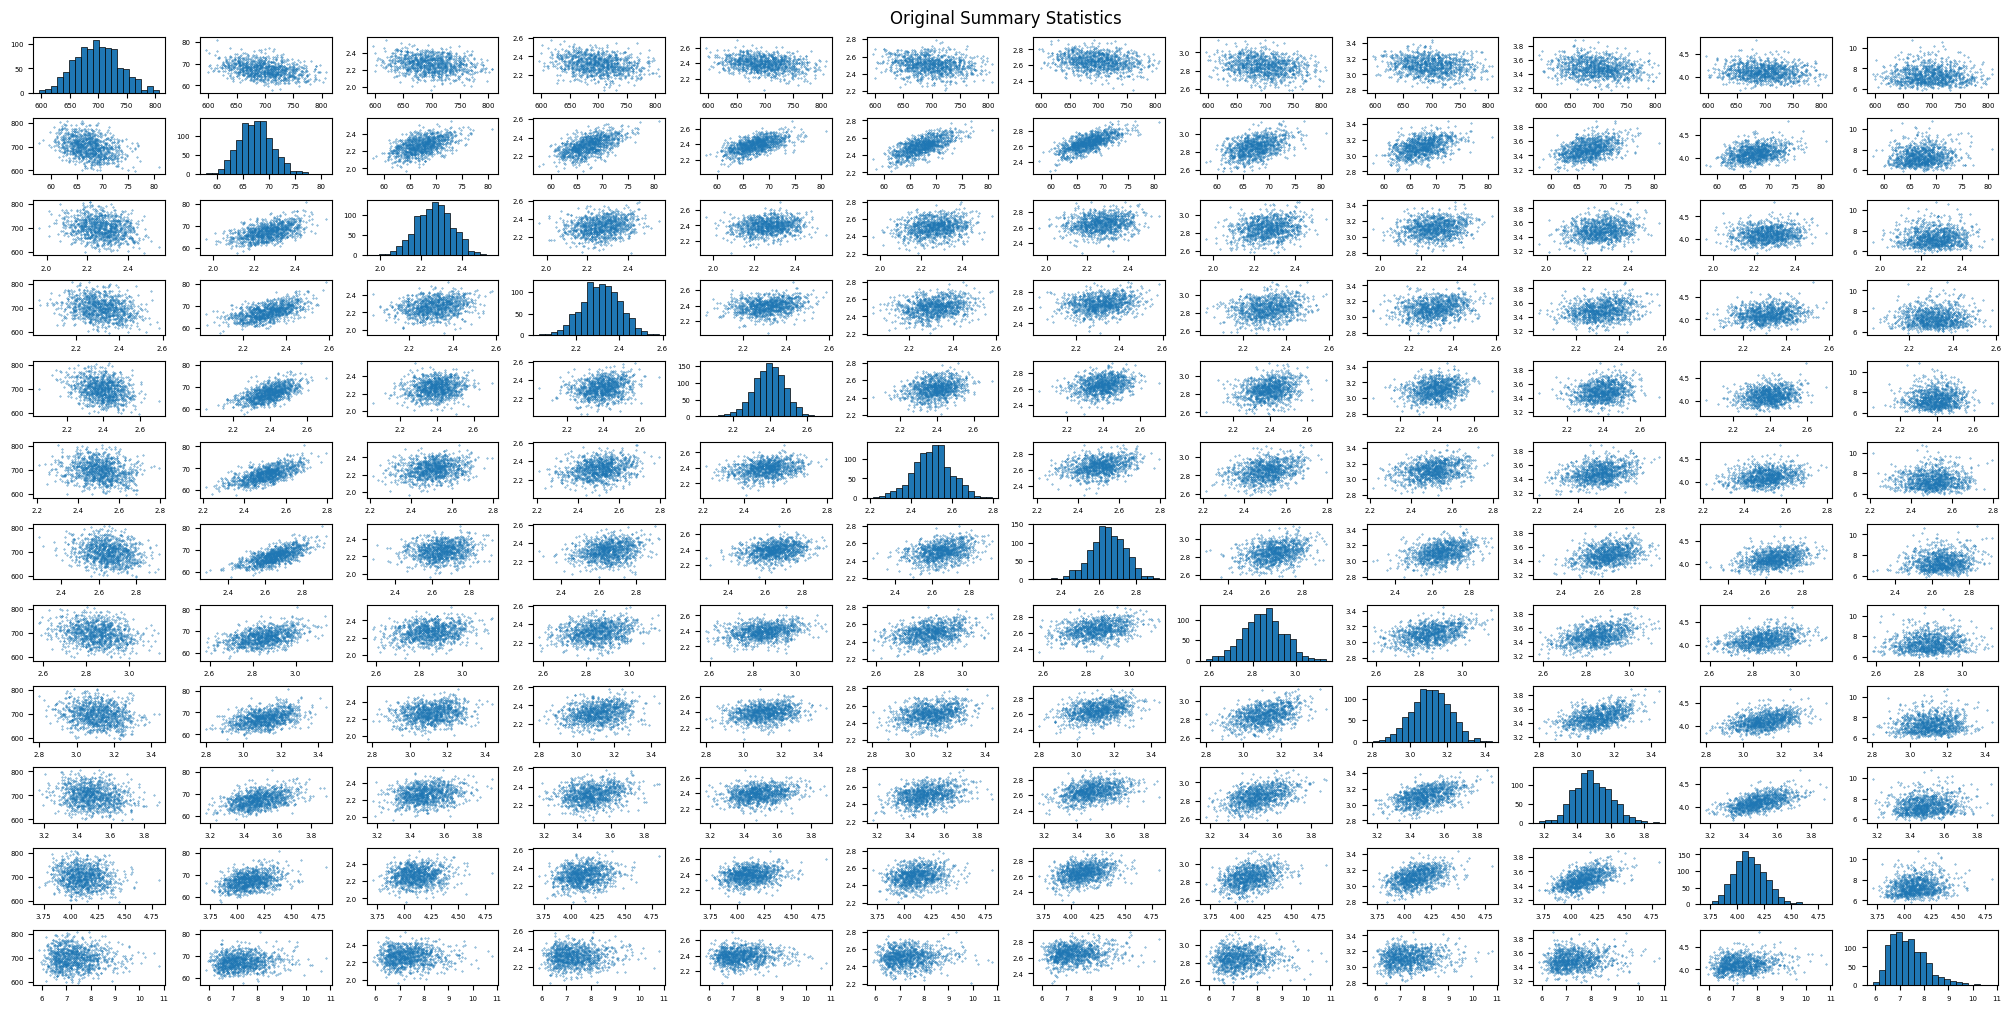

In [80]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(12, 12, figsize=(20,10), constrained_layout=True)

# For Sine Function
for x in range(12):
    for y in range(12):
        if x != y:
            axis[x, y].scatter(original_train_summary_statistics[:,x+36], original_train_summary_statistics[:,y+36], s = 0.1)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)
        else:
            axis[x, y].hist(original_train_summary_statistics[:,x+36], bins = 20, edgecolor='black', linewidth=0.5)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# Combine all the operations and display
figure.suptitle('Original Summary Statistics')
plt.show()

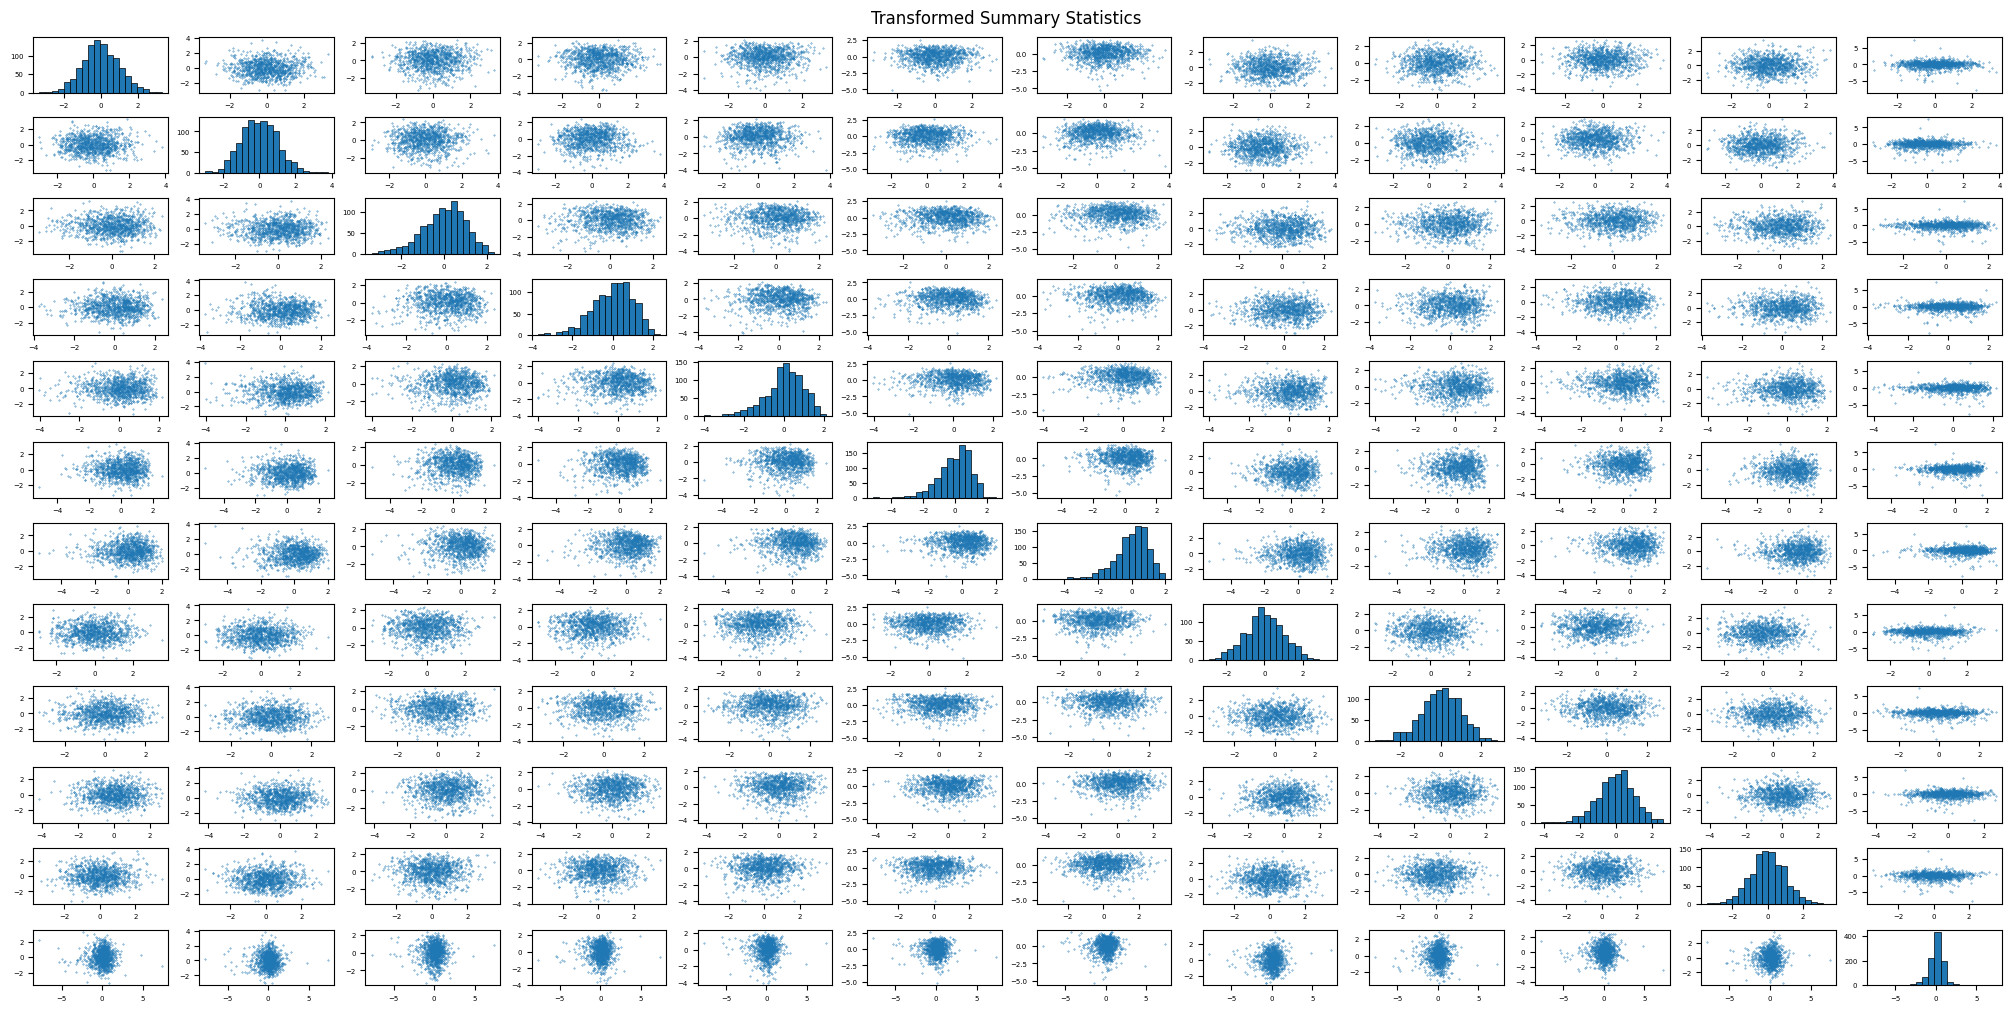

In [86]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(12, 12, figsize=(20,10), constrained_layout=True)

# For Sine Function
for x in range(12):
    for y in range(12):
        if x != y:
            axis[x, y].scatter(wass_train_summary_statistics[:,x], wass_train_summary_statistics[:,y], s = 0.1)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)
        else:
            axis[x, y].hist(wass_train_summary_statistics[:,x], bins = 20, edgecolor='black', linewidth=0.5)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# Combine all the operations and display
figure.suptitle('Transformed Summary Statistics')
plt.show()

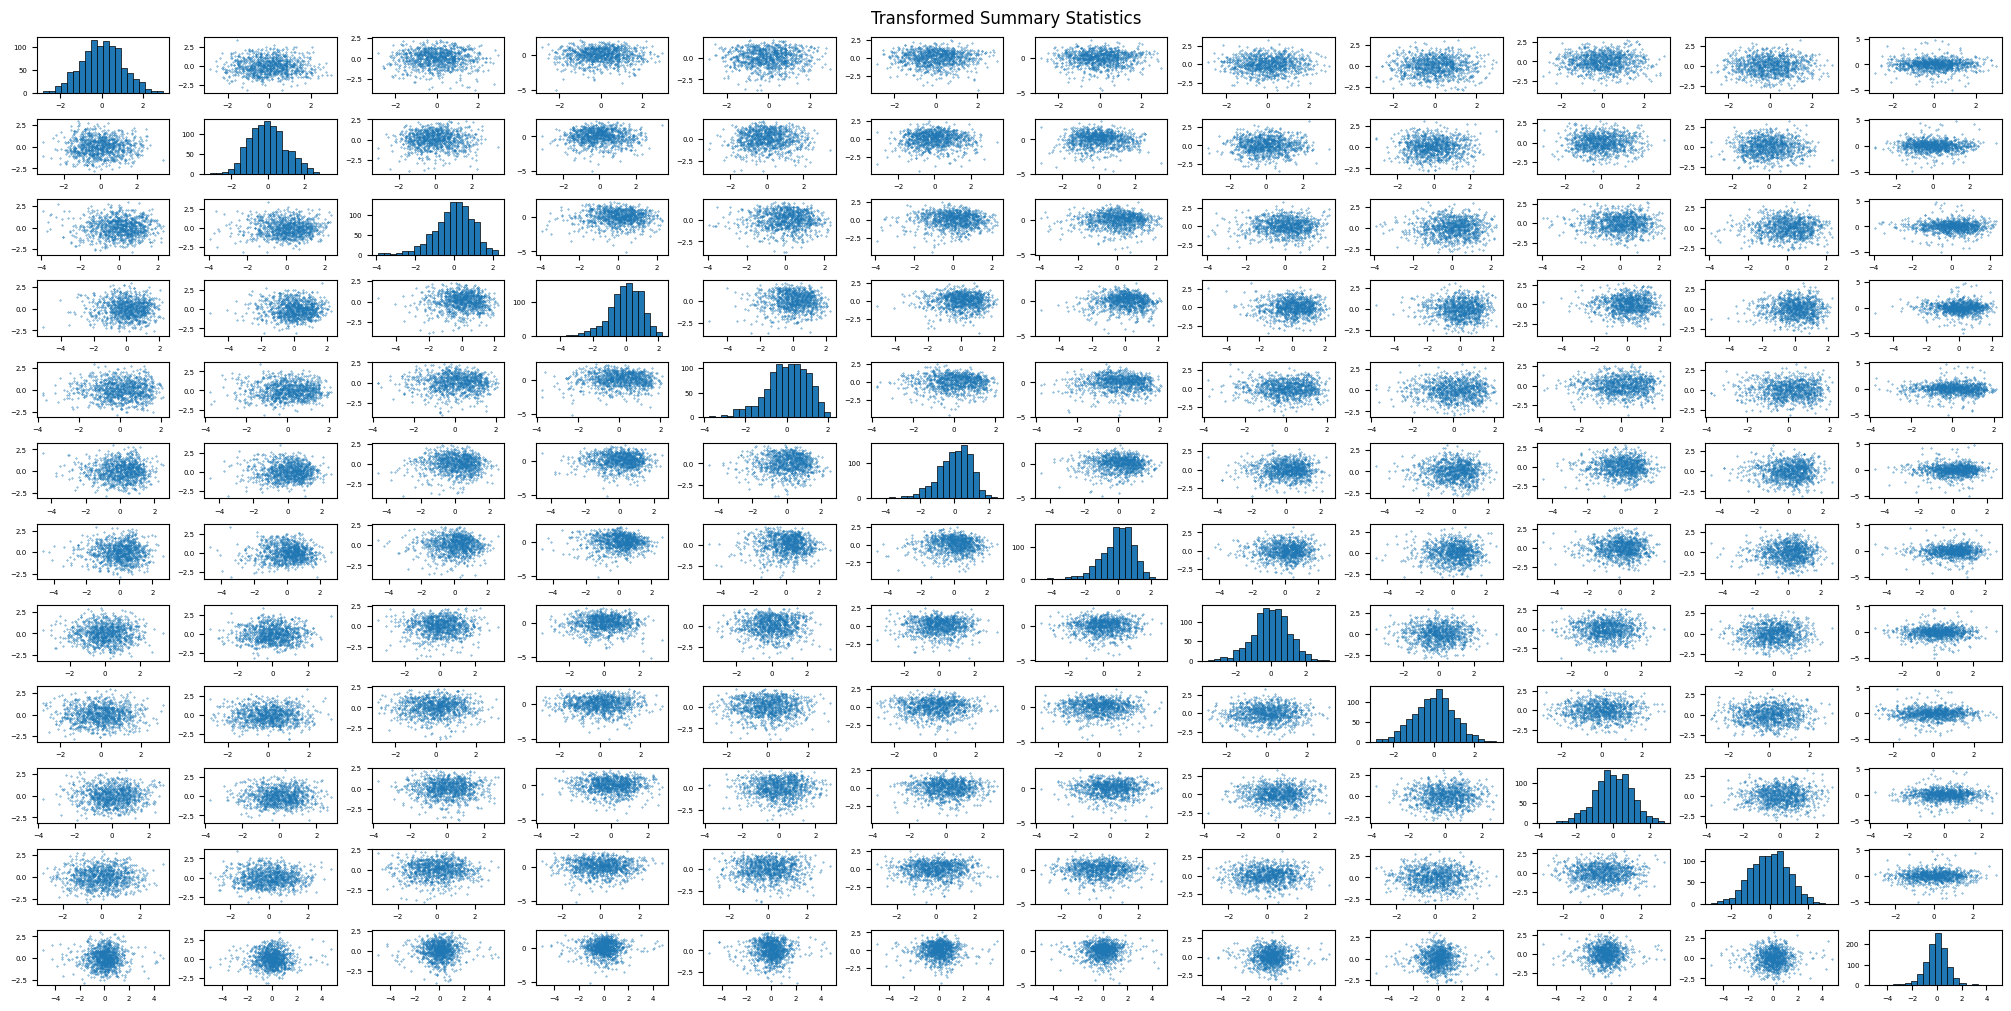

In [108]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(12, 12, figsize=(20,10), constrained_layout=True)

# For Sine Function
for x in range(12):
    for y in range(12):
        if x != y:
            axis[x, y].scatter(wass_train_summary_statistics[:,x+12], wass_train_summary_statistics[:,y+12], s = 0.1)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)
        else:
            axis[x, y].hist(wass_train_summary_statistics[:,x+12], bins = 20, edgecolor='black', linewidth=0.5)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# Combine all the operations and display
figure.suptitle('Transformed Summary Statistics')
plt.show()

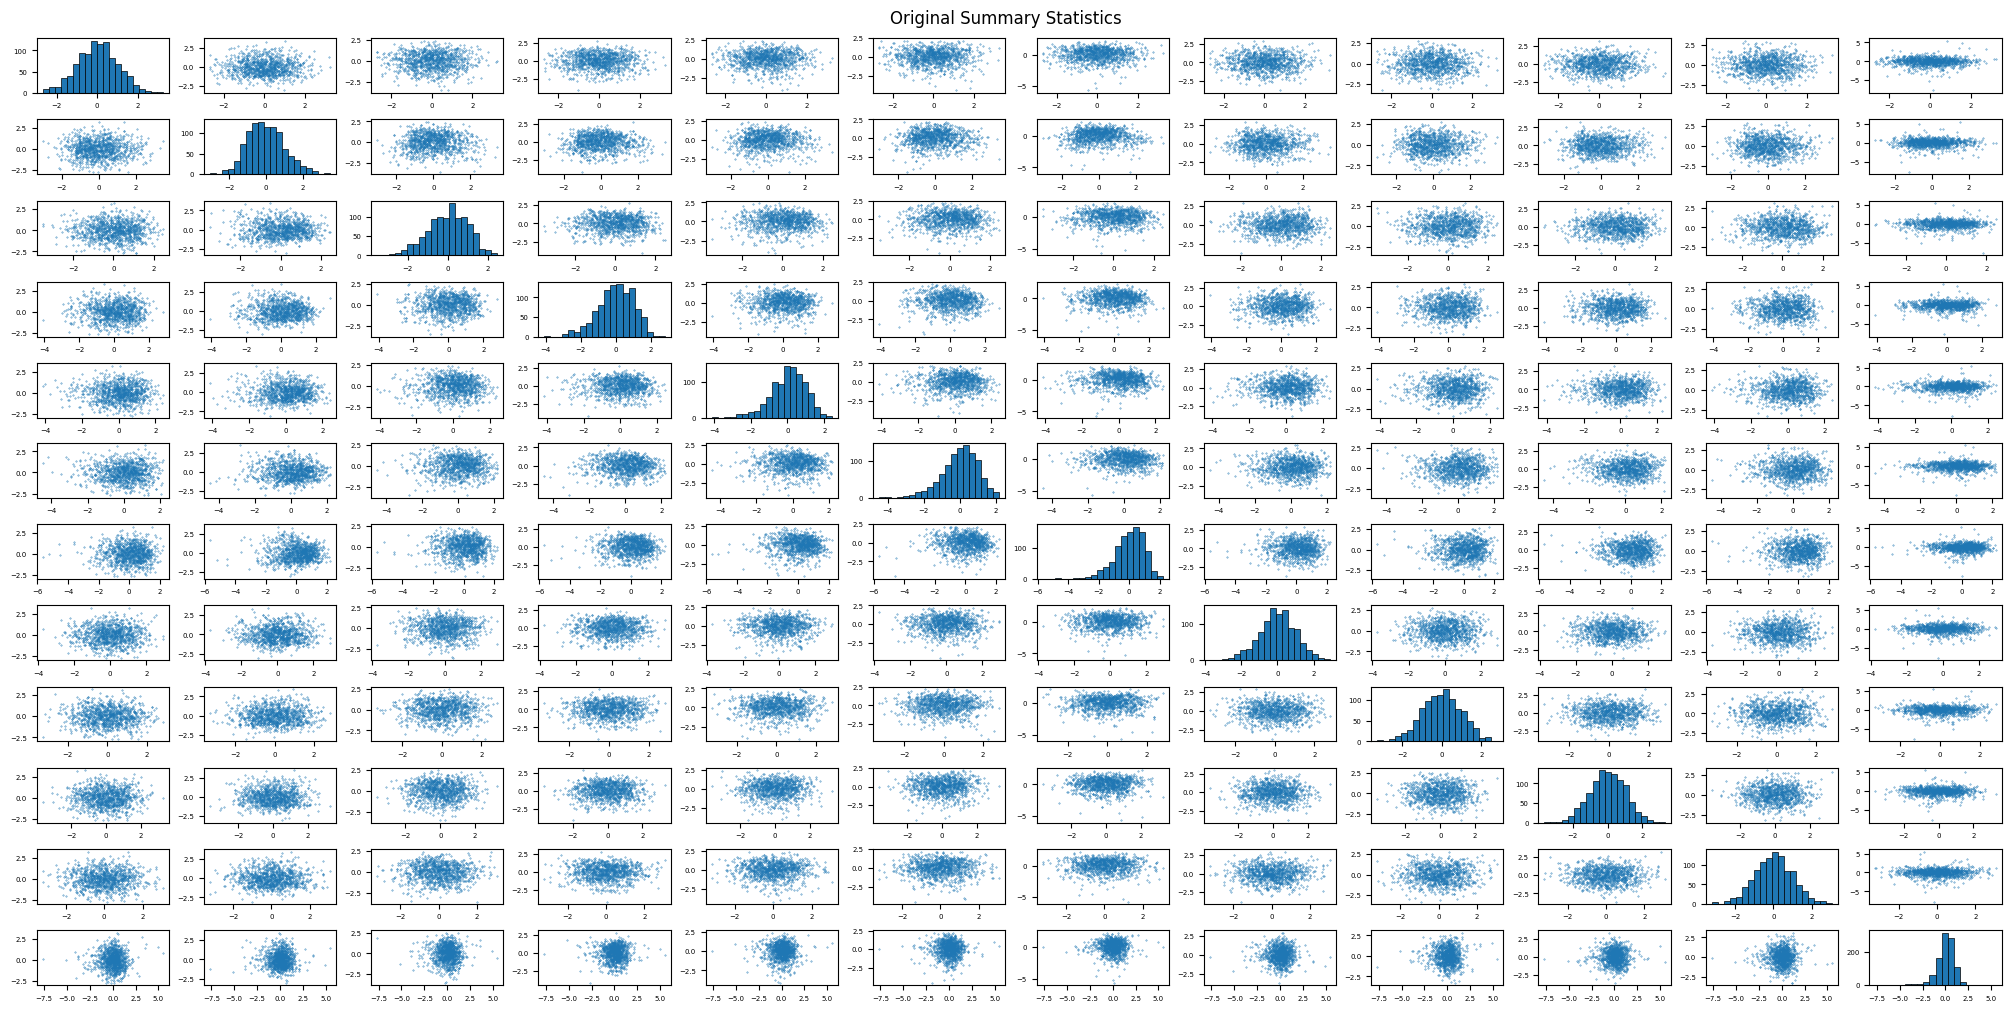

In [88]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(12, 12, figsize=(20,10), constrained_layout=True)

# For Sine Function
for x in range(12):
    for y in range(12):
        if x != y:
            axis[x, y].scatter(wass_train_summary_statistics[:,x+24], wass_train_summary_statistics[:,y+24], s = 0.1)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)
        else:
            axis[x, y].hist(wass_train_summary_statistics[:,x+24], bins = 20, edgecolor='black', linewidth=0.5)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# Combine all the operations and display
figure.suptitle('Transformed Summary Statistics')
plt.show()

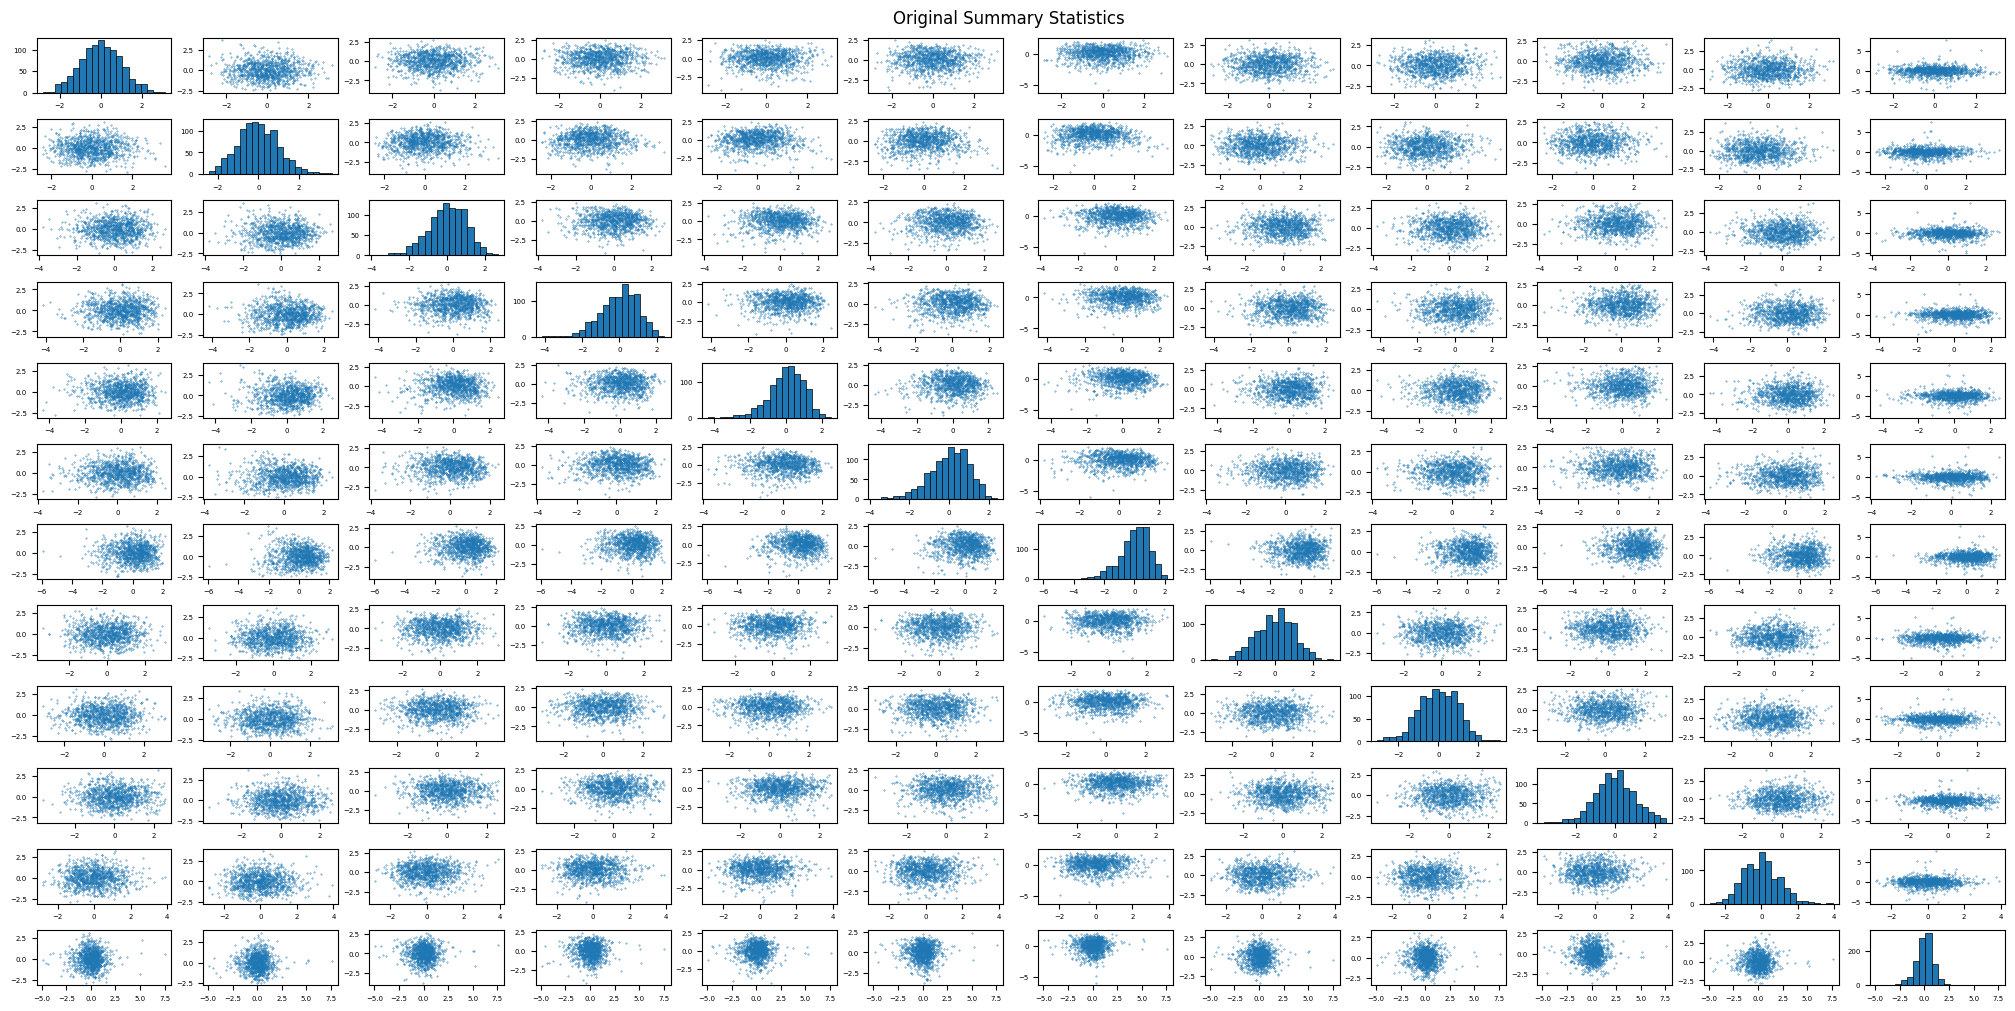

In [89]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(12, 12, figsize=(20,10), constrained_layout=True)

# For Sine Function
for x in range(12):
    for y in range(12):
        if x != y:
            axis[x, y].scatter(wass_train_summary_statistics[:,x+36], wass_train_summary_statistics[:,y+36], s = 0.1)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)
        else:
            axis[x, y].hist(wass_train_summary_statistics[:,x+36], bins = 20, edgecolor='black', linewidth=0.5)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# Combine all the operations and display
figure.suptitle('Transformed Summary Statistics')
plt.show()

<AxesSubplot: >

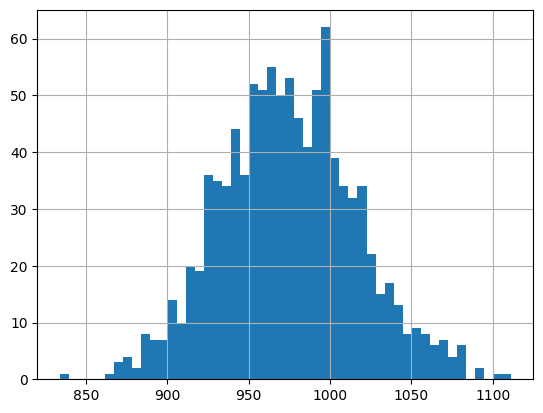

In [23]:
pd.Series(np.random.normal(np.mean(original_train_summary_statistics[:,0]),np.std(original_train_summary_statistics[:,0]), len(original_train_summary_statistics[:,0]))
).hist(bins = 50)

<AxesSubplot: >

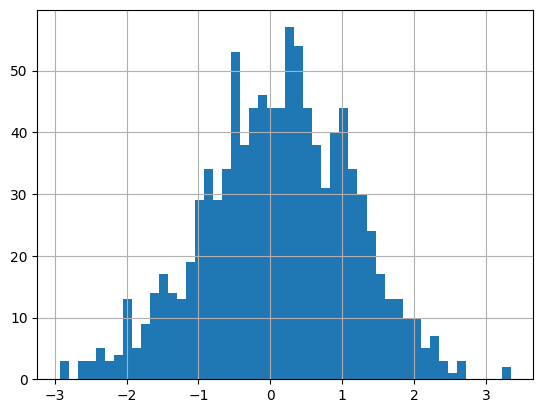

In [24]:
pd.Series(np.random.normal(np.mean(wass_train_summary_statistics[:,0]),np.std(wass_train_summary_statistics[:,0]), len(wass_train_summary_statistics[:,0]))
).hist(bins = 50)

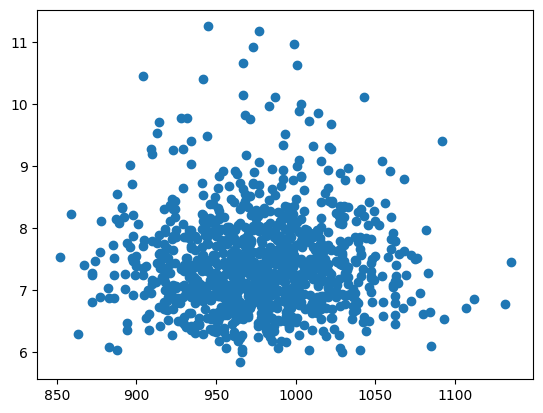

In [25]:
plt.scatter(original_train_summary_statistics[:,0], original_train_summary_statistics[:,47])

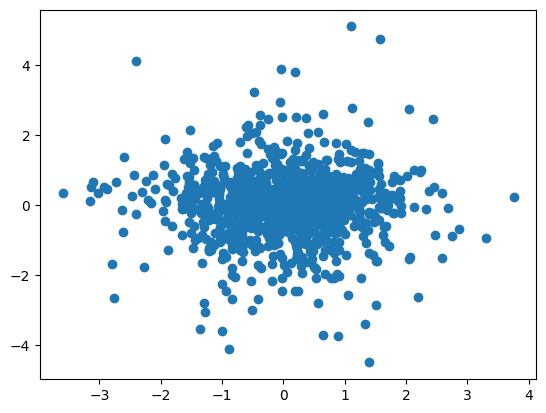

In [26]:
plt.scatter(wass_train_summary_statistics[:,0], wass_train_summary_statistics[:,47])

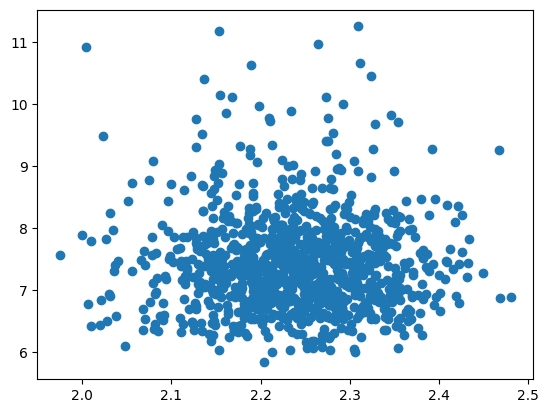

In [27]:
plt.scatter(original_train_summary_statistics[:,15], original_train_summary_statistics[:,47])

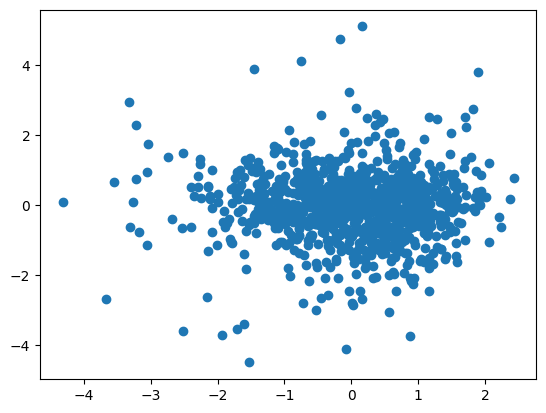

In [28]:
plt.scatter(wass_train_summary_statistics[:,15], wass_train_summary_statistics[:,47])

In [21]:
mixture_obj_seq = [i for i in mixture_obj_seq if i!=0]
# mixture_obj_seq = mixture_obj_seq[:-75]
mixture_obj_seq

[GaussianMixture(n_components=3, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(reg_covar=1e-05),
 GaussianMixture(reg_covar=1e-05),
 GaussianMixture(reg_covar=1e-05),
 GaussianMixture(reg_covar=1e-05),
 GaussianMixture(reg_covar=1e-05),
 GaussianMixture(reg_covar=1e-05),
 GaussianMixture(reg_covar=1e-05),
 GaussianMixture(reg_covar=1e-05),
 GaussianMixture(reg_covar=1e-05),
 GaussianMixture(reg_covar=1e-05),
 GaussianMixture(reg_covar=1e-05),
 GaussianMixture(reg_covar=1e-05),
 GaussianMixture(reg_covar=1e-05),
 GaussianMixture(reg_covar=1e-05),
 GaussianMixture(reg_covar=1e-05),
 GaussianMixture(reg_covar=1e-05),
 GaussianMixture(reg_covar=1e-05),
 GaussianMixture(reg_covar=1e-05),
 GaussianMixture(reg_covar=1e-05),
 GaussianMixture(reg_covar=1e-05),
 GaussianMixture(reg_covar=1e-05),
 GaussianMixture(reg_covar=1e-05),
 GaussianMixture(reg_covar

In [22]:
def wasserstein_transform(mixture_obj_seq, n_summary_statistics):
    for i in range(len(mixture_obj_seq)):
        stepsize = eps
        mixture_obj = mixture_obj_seq[i]
        grad_log_f = grad_log_density_mixture(n_summary_statistics, mixture_obj)[1]
        v = -n_summary_statistics-grad_log_f
        n_summary_statistics = n_summary_statistics + stepsize * v
    return n_summary_statistics

## FIND THE BEST THETA (COEFFICIENTS) USING VB

In [23]:
# Functions must be imported for multiprocessing to work
from f_gradient_lb_mean_wasserstein_nuissance_toad import (fun_gradient_lb)

In [24]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 200 # number of datasets
        self.num_coeffs = 3 # number of coeffs
        self.lambda_dim = self.num_coeffs + int((self.num_coeffs * (self.num_coeffs + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:self.num_coeffs])
        c_vech_l = np.array(c[self.num_coeffs:])
        return np.array([c_mu, c_vech_l], dtype = object)

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = np.array([np.log((true_theta[0] - 1)/(2 - true_theta[0])),np.log((true_theta[1] - 0)/(100 - true_theta[1])),np.log((true_theta[2] - 0)/(0.9 - true_theta[2]))])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        # l_0 = np.array([[ 3.94992238, -2.12969451,  0.47239626],
        #                 [-2.12969451, 21.85908684, -1.45228054],
        #                 [ 0.47239626, -1.45228054, 15.84326737]])
        l_0 = np.tril(np.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = my_inv(Sigma_0_inv)
        l_0_inv = my_inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices(self.num_coeffs)]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        for t in tqdm(range(stop)):
            if t == 0:        
                # Draw samples of theta from  variational q
                theta_0_samples = multivariate_normal.rvs(mean = mu_0, cov = Sigma_0, size = self.samples)

                # Multiprocessing a function with several inputs
                results = pool.map(partial(fun_gradient_lb, theta_samples = theta_0_samples, mu_q = mu_0, l_q = l_0, c = 0, n_samples = n_samples, n_datasets= self.num_datasets, num_coeffs = self.num_coeffs, num_latent = num_latent, actual_summary_statistics = self.actual_summary_statistics, mixture_obj_seq = mixture_obj_seq), np.arange(self.samples)) 
                results = np.reshape(results, (self.samples, 4))
                Gradient_lb_init = results[:,0]
                lb_0 = results[:,1]
                Flattened_gradient_lb = results[:,2]
                Flattened_gradient_log_q = results[:,3]

                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb_init, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(lb_0))
                print('LB', (np.mean(lb_0)))
                lambda_q = lambda_0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q[1])
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q[i:self.num_coeffs,i] = vech_lq[:self.num_coeffs - i]
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  my_inv(Sigma_q_inv)
                l_q_inv =  my_inv(l_q)

                theta_q_samples = multivariate_normal.rvs(mean = mu_q, cov = Sigma_q, size = self.samples)

                # Multiprocessing a function with several inputs
                results = pool.map(partial(fun_gradient_lb, theta_samples = theta_q_samples, mu_q = mu_q, l_q = l_q, c = c, n_samples = n_samples, n_datasets= self.num_datasets, num_coeffs = self.num_coeffs, num_latent = num_latent, actual_summary_statistics = self.actual_summary_statistics, mixture_obj_seq = mixture_obj_seq), np.arange(self.samples)) 
                results = np.reshape(results, (self.samples, 4))
                Gradient_lb = results[:,0]
                lb_t = results[:,1]
                Flattened_gradient_lb = results[:,2]
                Flattened_gradient_log_q = results[:,3]

                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)

                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(lb_t))

                if t < self.t_w:
                    print('LB', np.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

In [25]:
actual_summary_statistics = np.reshape(actual_summary_statistics, (1, len(actual_summary_statistics)))
actual_summary_statistics

array([[6.9246124 , 3.66996993, 6.30071171, 6.7178047 , 3.91656951,
        6.31433913, 6.66185474, 4.03792021, 6.47012367, 6.50578406,
        4.0408775 , 6.33987272]])

## RUN VB AND PRINT OUT VARIATIONAL PARAMS

In [26]:
# Set hyperparameters
stop = 5000
transformed_summary_statistics = wasserstein_transform(mixture_obj_seq, actual_summary_statistics)
transformed_summary_statistics[0]

array([ 3.74751333, -0.18901039,  0.48287884,  0.40854413, -0.55277389,
        0.50238291,  2.03371333,  1.70061491,  1.28299576, -0.85812423,
        1.31525913,  0.54627673])

In [27]:
vb = GVB(200, transformed_summary_statistics[0], 0.005, 2500, 100, 0.9, 0.9, 50, 50)
LB_estimate, smoothed_LB_estimate, best_lambda = vb.vb_posterior(stop)

  0%|          | 0/5000 [00:00<?, ?it/s]c:\Users\nngu8343\AppData\Local\miniconda3\envs\vbsl\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
  0%|          | 1/5000 [01:10<97:32:24, 70.24s/it]

LB -44.19796967017535


  0%|          | 2/5000 [02:13<91:25:51, 65.86s/it]

LB -43.913646687094854


  0%|          | 3/5000 [03:35<101:54:33, 73.42s/it]

LB -44.27513023173772


  0%|          | 4/5000 [04:58<107:17:23, 77.31s/it]

LB -44.67071779921655


  0%|          | 5/5000 [06:22<110:24:23, 79.57s/it]

LB -44.03221572749858


  0%|          | 6/5000 [07:44<111:47:32, 80.59s/it]

LB -44.19160666808546


  0%|          | 7/5000 [09:05<111:47:47, 80.61s/it]

LB -44.208710049142375


  0%|          | 8/5000 [10:26<112:07:17, 80.86s/it]

LB -44.45299423466196


  0%|          | 9/5000 [11:37<107:33:46, 77.59s/it]

LB -44.40679538258969


  0%|          | 10/5000 [12:50<105:50:19, 76.36s/it]

LB -44.09225575861378


  0%|          | 11/5000 [14:04<104:29:28, 75.40s/it]

LB -44.02359063972936


  0%|          | 12/5000 [15:28<108:03:57, 77.99s/it]

LB -43.95591670381008


  0%|          | 13/5000 [17:04<115:46:38, 83.58s/it]

LB -43.71081012786959


  0%|          | 14/5000 [18:52<126:06:17, 91.05s/it]

LB -44.03659651704382


  0%|          | 15/5000 [20:36<131:10:15, 94.73s/it]

LB -44.17730177386703


  0%|          | 16/5000 [22:12<131:41:30, 95.12s/it]

LB -43.844799025664145


  0%|          | 17/5000 [23:45<131:03:39, 94.69s/it]

LB -43.738576251867826


  0%|          | 18/5000 [25:16<129:27:03, 93.54s/it]

LB -43.83086419345923


  0%|          | 19/5000 [26:57<132:33:26, 95.81s/it]

LB -43.99725447573798


  0%|          | 20/5000 [28:21<127:34:01, 92.22s/it]

LB -44.08136381870454


  0%|          | 21/5000 [29:45<124:00:17, 89.66s/it]

LB -43.87745974376457


  0%|          | 22/5000 [31:22<127:04:42, 91.90s/it]

LB -44.129975324015795


  0%|          | 23/5000 [32:59<129:14:29, 93.48s/it]

LB -43.77082367224232


  0%|          | 24/5000 [34:29<127:35:49, 92.31s/it]

LB -43.43258569993995


  0%|          | 25/5000 [36:00<127:09:03, 92.01s/it]

LB -43.398426189589784


  1%|          | 26/5000 [37:33<127:37:03, 92.37s/it]

LB -43.48766875703755


  1%|          | 27/5000 [38:58<124:23:41, 90.05s/it]

LB -43.69893450155048


  1%|          | 28/5000 [40:43<130:46:03, 94.68s/it]

LB -43.675380968591114


  1%|          | 29/5000 [42:18<130:56:11, 94.82s/it]

LB -43.59265805406896


  1%|          | 30/5000 [44:25<144:07:16, 104.39s/it]

LB -43.39725461954535


  1%|          | 31/5000 [46:10<144:19:33, 104.56s/it]

LB -43.37526808661275


  1%|          | 32/5000 [48:11<151:04:48, 109.48s/it]

LB -43.13768005181003


  1%|          | 33/5000 [49:54<148:11:06, 107.40s/it]

LB -43.14968671871468


  1%|          | 34/5000 [52:05<158:02:42, 114.57s/it]

LB -43.44653426429519


  1%|          | 35/5000 [54:36<173:03:22, 125.48s/it]

LB -43.640774478851


  1%|          | 36/5000 [56:07<158:59:34, 115.31s/it]

LB -43.337760941932395


  1%|          | 37/5000 [57:36<148:02:39, 107.39s/it]

LB -43.05605001308579


  1%|          | 38/5000 [59:02<139:01:06, 100.86s/it]

LB -43.56960182306733


  1%|          | 39/5000 [1:00:39<137:14:51, 99.60s/it]

LB -43.5211584425855


  1%|          | 40/5000 [1:02:12<134:27:35, 97.59s/it]

LB -43.355300383717264


  1%|          | 41/5000 [1:04:21<147:29:10, 107.07s/it]

LB -43.39247194734068


  1%|          | 42/5000 [1:05:58<143:14:36, 104.01s/it]

LB -43.03593165727771


  1%|          | 43/5000 [1:07:30<138:35:04, 100.65s/it]

LB -43.274754943954456


  1%|          | 44/5000 [1:09:13<139:13:30, 101.13s/it]

LB -43.042544433353996


  1%|          | 45/5000 [1:10:59<141:12:44, 102.60s/it]

LB -42.839736280707754


  1%|          | 46/5000 [1:12:42<141:31:10, 102.84s/it]

LB -43.15119718154831


  1%|          | 47/5000 [1:14:31<144:10:29, 104.79s/it]

LB -42.80936437472242


  1%|          | 48/5000 [1:16:17<144:22:08, 104.95s/it]

LB -42.83041272307905


  1%|          | 49/5000 [1:17:48<138:41:39, 100.85s/it]

LB -43.351209632902666


  1%|          | 50/5000 [1:19:17<133:46:07, 97.29s/it] 

LB -43.23235211112393


  1%|          | 51/5000 [1:20:55<133:56:24, 97.43s/it]

LB Smoothed -43.645961307906596


  1%|          | 52/5000 [1:22:52<141:53:30, 103.24s/it]

LB Smoothed -43.6233625277751


  1%|          | 53/5000 [1:24:58<151:22:44, 110.16s/it]

LB Smoothed -43.59968782191088


  1%|          | 54/5000 [1:27:02<157:11:21, 114.41s/it]

LB Smoothed -43.56180103484752


  1%|          | 55/5000 [1:29:06<160:56:27, 117.17s/it]

LB Smoothed -43.539806053614235


  1%|          | 56/5000 [1:31:10<163:56:50, 119.38s/it]

LB Smoothed -43.51266873899653


  1%|          | 57/5000 [1:33:14<165:50:31, 120.78s/it]

LB Smoothed -43.4881786031946


  1%|          | 58/5000 [1:35:06<161:57:37, 117.98s/it]

LB Smoothed -43.45524599409467


  1%|          | 59/5000 [1:36:16<142:19:43, 103.70s/it]

LB Smoothed -43.41895522548382


  1%|          | 60/5000 [1:37:33<131:08:57, 95.57s/it] 

LB Smoothed -43.39097387643087


  1%|          | 61/5000 [1:38:48<122:51:13, 89.55s/it]

LB Smoothed -43.360692939697834


  1%|          | 62/5000 [1:39:56<113:57:03, 83.07s/it]

LB Smoothed -43.33821125499283


  1%|▏         | 63/5000 [1:41:01<106:15:59, 77.49s/it]

LB Smoothed -43.320346562220216


  1%|▏         | 64/5000 [1:42:06<101:20:43, 73.91s/it]

LB Smoothed -43.290523781803444


  1%|▏         | 65/5000 [1:43:23<102:29:51, 74.77s/it]

LB Smoothed -43.25582879338339


  1%|▏         | 66/5000 [1:44:35<101:21:44, 73.96s/it]

LB Smoothed -43.22610298676629


  1%|▏         | 67/5000 [1:45:43<98:39:34, 72.00s/it] 

LB Smoothed -43.20232031668135


  1%|▏         | 68/5000 [1:46:49<96:17:32, 70.29s/it]

LB Smoothed -43.177520304696166


  1%|▏         | 69/5000 [1:47:56<94:46:55, 69.20s/it]

LB Smoothed -43.14166355841135


  1%|▏         | 70/5000 [1:49:05<94:48:32, 69.23s/it]

LB Smoothed -43.10974742516818


  1%|▏         | 71/5000 [1:50:12<93:56:04, 68.61s/it]

LB Smoothed -43.08157163119907


  1%|▏         | 72/5000 [1:51:20<93:37:50, 68.40s/it]

LB Smoothed -43.04936682648985


  1%|▏         | 73/5000 [1:52:32<94:57:13, 69.38s/it]

LB Smoothed -43.02317726093217


  1%|▏         | 74/5000 [1:53:42<95:27:44, 69.77s/it]

LB Smoothed -43.005010614260144


  2%|▏         | 75/5000 [1:54:51<94:58:22, 69.42s/it]

LB Smoothed -42.98816108220266


  2%|▏         | 76/5000 [1:56:02<95:28:54, 69.81s/it]

LB Smoothed -42.96716748038049


  2%|▏         | 77/5000 [1:57:10<94:46:30, 69.31s/it]

LB Smoothed -42.93806019288923


  2%|▏         | 78/5000 [1:58:18<94:23:44, 69.04s/it]

LB Smoothed -42.908210565910764


  2%|▏         | 79/5000 [1:59:30<95:44:33, 70.04s/it]

LB Smoothed -42.878484202120134


  2%|▏         | 80/5000 [2:01:27<114:55:15, 84.09s/it]

LB Smoothed -42.85892392344425


  2%|▏         | 81/5000 [2:03:56<141:26:33, 103.52s/it]

LB Smoothed -42.83120879819195


  2%|▏         | 82/5000 [2:06:46<168:39:31, 123.46s/it]

LB Smoothed -42.813340728705974


  2%|▏         | 83/5000 [2:09:35<187:11:58, 137.06s/it]

LB Smoothed -42.79163038069449


  2%|▏         | 84/5000 [2:12:23<199:51:22, 146.36s/it]

LB Smoothed -42.76301104085476


  2%|▏         | 85/5000 [2:15:03<205:14:55, 150.33s/it]

LB Smoothed -42.73642386451247


  2%|▏         | 86/5000 [2:17:50<212:08:17, 155.41s/it]

LB Smoothed -42.71831450888281


  2%|▏         | 87/5000 [2:20:43<219:20:02, 160.72s/it]

LB Smoothed -42.6955748021248


  2%|▏         | 88/5000 [2:24:12<239:04:16, 175.21s/it]

LB Smoothed -42.66732911128465


  2%|▏         | 89/5000 [2:27:53<257:33:44, 188.81s/it]

LB Smoothed -42.63325303657126


  2%|▏         | 90/5000 [2:31:19<264:39:51, 194.05s/it]

LB Smoothed -42.611913584013706


  2%|▏         | 91/5000 [2:34:38<266:30:34, 195.44s/it]

LB Smoothed -42.58301931701583


  2%|▏         | 92/5000 [2:37:39<260:38:56, 191.19s/it]

LB Smoothed -42.5594410401471


  2%|▏         | 93/5000 [2:40:41<257:07:42, 188.64s/it]

LB Smoothed -42.528401162484165


  2%|▏         | 94/5000 [2:43:47<255:59:23, 187.84s/it]

LB Smoothed -42.51060948986894


  2%|▏         | 95/5000 [2:46:46<251:58:07, 184.93s/it]

LB Smoothed -42.49202290297225


  2%|▏         | 96/5000 [2:49:34<245:08:14, 179.95s/it]

LB Smoothed -42.46603801529641


  2%|▏         | 97/5000 [2:52:00<231:12:16, 169.76s/it]

LB Smoothed -42.44843571161907


  2%|▏         | 98/5000 [2:54:34<224:50:31, 165.12s/it]

LB Smoothed -42.43112268030699


  2%|▏         | 99/5000 [2:57:07<219:57:00, 161.56s/it]

LB Smoothed -42.399856977076126


  2%|▏         | 100/5000 [2:59:33<213:09:48, 156.61s/it]

LB Smoothed -42.368524501379035


  2%|▏         | 101/5000 [3:02:24<219:01:50, 160.95s/it]

LB Smoothed -42.34611124771105


  2%|▏         | 102/5000 [3:05:11<221:44:02, 162.97s/it]

LB Smoothed -42.317953109344856


  2%|▏         | 103/5000 [3:08:07<226:44:21, 166.69s/it]

LB Smoothed -42.297778945967515


  2%|▏         | 104/5000 [3:11:09<233:10:15, 171.45s/it]

LB Smoothed -42.275641818712366


  2%|▏         | 105/5000 [3:14:20<241:06:36, 177.32s/it]

LB Smoothed -42.25759725990528


  2%|▏         | 106/5000 [3:17:34<247:45:31, 182.25s/it]

LB Smoothed -42.235101924439135


  2%|▏         | 107/5000 [3:20:34<246:46:29, 181.56s/it]

LB Smoothed -42.216099802887456


  2%|▏         | 108/5000 [3:23:34<246:01:10, 181.04s/it]

LB Smoothed -42.19779323282254


  2%|▏         | 109/5000 [3:26:21<240:16:30, 176.85s/it]

LB Smoothed -42.17733183959973


  2%|▏         | 110/5000 [6:36:45<4823:34:43, 3551.10s/it]

LB Smoothed -42.15840963623865


  2%|▏         | 111/5000 [6:38:56<3429:08:04, 2525.03s/it]

LB Smoothed -42.134775016568646


  2%|▏         | 112/5000 [6:40:58<2449:38:33, 1804.16s/it]

LB Smoothed -42.11590648361129


  2%|▏         | 113/5000 [6:43:11<1768:27:56, 1302.74s/it]

LB Smoothed -42.09658349378752


  2%|▏         | 114/5000 [6:45:26<1292:29:31, 952.31s/it] 

LB Smoothed -42.08145185186634


  2%|▏         | 115/5000 [6:47:36<957:49:46, 705.87s/it] 

LB Smoothed -42.06790245983093


  2%|▏         | 116/5000 [6:49:48<723:42:27, 533.45s/it]

LB Smoothed -42.047299089510524


  2%|▏         | 117/5000 [6:51:55<558:26:59, 411.72s/it]

LB Smoothed -42.02548059850523


  2%|▏         | 118/5000 [6:53:57<440:23:48, 324.75s/it]

LB Smoothed -42.00806139083233


  2%|▏         | 119/5000 [6:56:00<358:17:29, 264.26s/it]

LB Smoothed -41.99242305190923


  2%|▏         | 120/5000 [6:58:11<303:46:52, 224.10s/it]

LB Smoothed -41.976066821692925


  2%|▏         | 121/5000 [7:00:13<262:21:10, 193.58s/it]

LB Smoothed -41.96069637919242


  2%|▏         | 122/5000 [7:02:17<233:59:44, 172.69s/it]

LB Smoothed -41.941128671592246


  2%|▏         | 123/5000 [7:04:23<214:56:56, 158.67s/it]

LB Smoothed -41.92251604351687


  2%|▏         | 124/5000 [7:06:26<200:37:25, 148.12s/it]

LB Smoothed -41.90342528954125


  2%|▎         | 125/5000 [7:08:35<192:45:18, 142.34s/it]

LB Smoothed -41.88521162535204


  3%|▎         | 126/5000 [7:10:39<185:08:23, 136.75s/it]

LB Smoothed -41.87676556143667


  3%|▎         | 127/5000 [7:12:55<184:39:22, 136.42s/it]

LB Smoothed -41.866909644073836


  3%|▎         | 128/5000 [7:15:02<180:50:19, 133.62s/it]

LB Smoothed -41.850506440455995


  3%|▎         | 129/5000 [7:17:09<178:04:15, 131.61s/it]

LB Smoothed -41.832287785852344


  3%|▎         | 130/5000 [7:19:18<177:08:53, 130.95s/it]

LB Smoothed -41.82788777576801


  3%|▎         | 131/5000 [7:21:39<181:05:14, 133.89s/it]

LB Smoothed -41.81500032902937


  3%|▎         | 132/5000 [7:23:53<181:05:10, 133.92s/it]

LB Smoothed -41.80574405374698


  3%|▎         | 133/5000 [7:25:58<177:28:11, 131.27s/it]

LB Smoothed -41.796527597779395


  3%|▎         | 134/5000 [7:28:13<178:56:55, 132.39s/it]

LB Smoothed -41.78154379626051


  3%|▎         | 135/5000 [7:30:23<178:02:06, 131.74s/it]

LB Smoothed -41.76444285521671


  3%|▎         | 136/5000 [7:32:40<180:15:13, 133.41s/it]

LB Smoothed -41.75785466453205


  3%|▎         | 137/5000 [7:34:53<179:51:04, 133.14s/it]

LB Smoothed -41.747811611461636


  3%|▎         | 138/5000 [7:37:09<181:06:14, 134.10s/it]

LB Smoothed -41.744139124093316


  3%|▎         | 139/5000 [7:39:23<180:53:17, 133.96s/it]

LB Smoothed -41.73279994231191


  3%|▎         | 140/5000 [7:41:30<177:57:37, 131.82s/it]

LB Smoothed -41.729811734023265


  3%|▎         | 141/5000 [7:43:43<178:24:46, 132.18s/it]

LB Smoothed -41.71780745655214


  3%|▎         | 142/5000 [7:45:51<176:56:54, 131.13s/it]

LB Smoothed -41.718884874238


  3%|▎         | 143/5000 [7:47:54<173:40:37, 128.73s/it]

LB Smoothed -41.71122547117845


  3%|▎         | 144/5000 [7:50:03<173:36:56, 128.71s/it]

LB Smoothed -41.70882523077575


  3%|▎         | 145/5000 [7:52:23<178:01:42, 132.01s/it]

LB Smoothed -41.70110144305955


  3%|▎         | 146/5000 [7:54:37<178:57:53, 132.73s/it]

LB Smoothed -41.69597410495325


  3%|▎         | 147/5000 [7:57:08<186:11:57, 138.12s/it]

LB Smoothed -41.68861341473246


  3%|▎         | 148/5000 [7:59:54<197:33:18, 146.58s/it]

LB Smoothed -41.687268346079634


  3%|▎         | 149/5000 [8:02:45<207:19:12, 153.86s/it]

LB Smoothed -41.693078727475275


  3%|▎         | 150/5000 [8:05:34<213:29:38, 158.47s/it]

LB Smoothed -41.692783342011545


  3%|▎         | 151/5000 [8:08:28<219:36:47, 163.05s/it]

LB Smoothed -41.69169757467764


  3%|▎         | 152/5000 [8:11:19<222:52:33, 165.50s/it]

LB Smoothed -41.69261988998652


  3%|▎         | 153/5000 [8:14:05<222:43:49, 165.43s/it]

LB Smoothed -41.68644450172295


  3%|▎         | 154/5000 [8:16:59<226:19:41, 168.13s/it]

LB Smoothed -41.67888197070739


  3%|▎         | 155/5000 [8:20:02<232:09:45, 172.50s/it]

LB Smoothed -41.67152705537178


  3%|▎         | 156/5000 [8:22:53<231:25:17, 171.99s/it]

LB Smoothed -41.66198621496536


  3%|▎         | 157/5000 [8:25:35<227:44:12, 169.29s/it]

LB Smoothed -41.65551681372424


  3%|▎         | 158/5000 [8:28:19<225:16:28, 167.49s/it]

LB Smoothed -41.65004988664554


  3%|▎         | 159/5000 [8:30:58<221:53:14, 165.01s/it]

LB Smoothed -41.647818385634494


  3%|▎         | 160/5000 [8:33:38<219:50:03, 163.51s/it]

LB Smoothed -41.64784948218805


  3%|▎         | 161/5000 [8:36:23<220:22:13, 163.95s/it]

LB Smoothed -41.64105493861617


  3%|▎         | 162/5000 [8:39:11<221:46:38, 165.03s/it]

LB Smoothed -41.63397559619998


  3%|▎         | 163/5000 [8:41:56<222:06:16, 165.30s/it]

LB Smoothed -41.625476703842494


  3%|▎         | 164/5000 [8:44:44<222:53:59, 165.93s/it]

LB Smoothed -41.62043526225033


  3%|▎         | 165/5000 [8:47:30<222:52:35, 165.95s/it]

LB Smoothed -41.62000510605895


  3%|▎         | 166/5000 [8:50:20<224:33:54, 167.24s/it]

LB Smoothed -41.619945757422


  3%|▎         | 167/5000 [8:53:07<224:24:17, 167.15s/it]

LB Smoothed -41.61966415478092


  3%|▎         | 168/5000 [8:56:00<226:34:32, 168.81s/it]

LB Smoothed -41.61381596065603


  3%|▎         | 169/5000 [8:58:56<229:22:52, 170.93s/it]

LB Smoothed -41.6091908947318


  3%|▎         | 170/5000 [9:01:49<230:24:38, 171.73s/it]

LB Smoothed -41.599508404770965


  3%|▎         | 171/5000 [9:04:37<228:39:23, 170.46s/it]

LB Smoothed -41.596342498232886


  3%|▎         | 172/5000 [9:07:22<226:40:34, 169.02s/it]

LB Smoothed -41.59363942648486


  3%|▎         | 173/5000 [9:10:00<222:14:15, 165.75s/it]

LB Smoothed -41.59039936291157


  3%|▎         | 174/5000 [9:12:33<216:57:17, 161.84s/it]

LB Smoothed -41.595276508247636


  4%|▎         | 175/5000 [9:15:06<213:25:16, 159.24s/it]

LB Smoothed -41.586611727550356


  4%|▎         | 176/5000 [9:17:47<214:02:23, 159.73s/it]

LB Smoothed -41.577206280014025


  4%|▎         | 177/5000 [9:20:38<218:34:12, 163.15s/it]

LB Smoothed -41.57926748050725


  4%|▎         | 178/5000 [9:23:19<217:37:41, 162.48s/it]

LB Smoothed -41.57976640664961


  4%|▎         | 179/5000 [9:26:01<217:21:00, 162.30s/it]

LB Smoothed -41.573537607341926


  4%|▎         | 180/5000 [9:28:40<216:04:37, 161.39s/it]

LB Smoothed -41.5678126806966


  4%|▎         | 181/5000 [9:31:14<213:04:24, 159.18s/it]

LB Smoothed -41.56314704263572


  4%|▎         | 182/5000 [9:33:47<210:23:32, 157.20s/it]

LB Smoothed -41.56176319345063


  4%|▎         | 183/5000 [9:36:26<211:12:49, 157.85s/it]

LB Smoothed -41.561076231603515


  4%|▎         | 184/5000 [9:39:07<212:19:22, 158.71s/it]

LB Smoothed -41.56037750732164


  4%|▎         | 185/5000 [9:41:47<212:33:02, 158.92s/it]

LB Smoothed -41.55463175003478


  4%|▎         | 186/5000 [9:44:26<212:45:06, 159.10s/it]

LB Smoothed -41.54725033543647


  4%|▎         | 187/5000 [9:47:03<211:59:43, 158.57s/it]

LB Smoothed -41.54609702405574


  4%|▍         | 188/5000 [9:49:42<211:59:39, 158.60s/it]

LB Smoothed -41.53836080916709


  4%|▍         | 189/5000 [9:52:22<212:39:27, 159.13s/it]

LB Smoothed -41.53149394402598


  4%|▍         | 190/5000 [9:55:03<213:22:08, 159.69s/it]

LB Smoothed -41.53131041208623


  4%|▍         | 191/5000 [9:57:42<212:57:18, 159.42s/it]

LB Smoothed -41.52932967172137


  4%|▍         | 192/5000 [10:00:22<212:59:47, 159.48s/it]

LB Smoothed -41.52390743593236


  4%|▍         | 193/5000 [10:03:09<216:08:15, 161.87s/it]

LB Smoothed -41.517782155597914


  4%|▍         | 194/5000 [10:06:03<220:43:16, 165.33s/it]

LB Smoothed -41.514250467676725


  4%|▍         | 195/5000 [10:08:47<220:27:20, 165.17s/it]

LB Smoothed -41.5059949868915


  4%|▍         | 196/5000 [10:11:20<215:31:52, 161.51s/it]

LB Smoothed -41.50222809466917


  4%|▍         | 197/5000 [10:13:56<213:08:46, 159.76s/it]

LB Smoothed -41.4965164071306


  4%|▍         | 198/5000 [10:16:36<213:08:56, 159.80s/it]

LB Smoothed -41.487799836380454


  4%|▍         | 199/5000 [10:19:18<214:06:15, 160.54s/it]

LB Smoothed -41.472129994558635


  4%|▍         | 200/5000 [10:22:08<217:39:29, 163.24s/it]

LB Smoothed -41.4657286159116


  4%|▍         | 201/5000 [10:24:48<216:27:58, 162.38s/it]

LB Smoothed -41.45371157205368


  4%|▍         | 202/5000 [10:27:25<214:07:46, 160.66s/it]

LB Smoothed -41.450279868741305


  4%|▍         | 203/5000 [10:30:00<211:57:27, 159.07s/it]

LB Smoothed -41.44837479732986


  4%|▍         | 204/5000 [10:32:33<209:32:17, 157.28s/it]

LB Smoothed -41.446001229416474


  4%|▍         | 205/5000 [10:35:15<211:12:40, 158.57s/it]

LB Smoothed -41.44619260929658


  4%|▍         | 206/5000 [10:37:56<212:04:25, 159.25s/it]

LB Smoothed -41.448330956170516


  4%|▍         | 207/5000 [10:40:36<212:25:08, 159.55s/it]

LB Smoothed -41.444973904890055


  4%|▍         | 208/5000 [10:43:16<212:23:05, 159.55s/it]

LB Smoothed -41.440634807144164


  4%|▍         | 209/5000 [10:45:57<213:11:15, 160.19s/it]

LB Smoothed -41.429621461365294


  4%|▍         | 210/5000 [10:48:36<212:32:17, 159.74s/it]

LB Smoothed -41.421744103900096


  4%|▍         | 211/5000 [10:51:19<213:55:35, 160.81s/it]

LB Smoothed -41.43040693690918


  4%|▍         | 212/5000 [10:53:55<211:57:57, 159.37s/it]

LB Smoothed -41.428369770321716


  4%|▍         | 213/5000 [10:56:37<212:55:07, 160.12s/it]

LB Smoothed -41.431281592680314


  4%|▍         | 214/5000 [10:59:17<212:58:10, 160.19s/it]

LB Smoothed -41.43504102695443


  4%|▍         | 215/5000 [11:01:58<213:03:06, 160.29s/it]

LB Smoothed -41.431286337496694


  4%|▍         | 216/5000 [11:04:38<213:00:39, 160.29s/it]

LB Smoothed -41.439472207968414


  4%|▍         | 217/5000 [11:07:20<213:27:21, 160.66s/it]

LB Smoothed -41.43817165228446


  4%|▍         | 218/5000 [11:10:08<216:32:34, 163.02s/it]

LB Smoothed -41.43694633624287


  4%|▍         | 219/5000 [11:12:53<217:13:06, 163.56s/it]

LB Smoothed -41.435341709546414


  4%|▍         | 220/5000 [11:15:35<216:19:46, 162.93s/it]

LB Smoothed -41.43960294919329


  4%|▍         | 221/5000 [11:18:16<215:29:30, 162.33s/it]

LB Smoothed -41.43645719660123


  4%|▍         | 222/5000 [11:21:02<217:07:41, 163.60s/it]

LB Smoothed -41.43607146277893


  4%|▍         | 223/5000 [11:23:48<218:02:29, 164.32s/it]

LB Smoothed -41.424607814919156


  4%|▍         | 224/5000 [11:26:27<215:53:31, 162.73s/it]

LB Smoothed -41.425520008119


  4%|▍         | 225/5000 [11:29:07<214:33:28, 161.76s/it]

LB Smoothed -41.42897132558463


  5%|▍         | 226/5000 [11:31:41<211:37:42, 159.59s/it]

LB Smoothed -41.43063151735044


  5%|▍         | 227/5000 [11:34:17<210:01:55, 158.42s/it]

LB Smoothed -41.426432223466485


  5%|▍         | 228/5000 [11:36:58<211:08:06, 159.28s/it]

LB Smoothed -41.42063406343263


  5%|▍         | 229/5000 [11:39:39<211:48:36, 159.82s/it]

LB Smoothed -41.42111360448064


  5%|▍         | 230/5000 [11:42:19<211:55:56, 159.95s/it]

LB Smoothed -41.42476099215408


  5%|▍         | 231/5000 [11:44:58<211:15:16, 159.47s/it]

LB Smoothed -41.423446495933554


  5%|▍         | 232/5000 [11:47:34<209:56:44, 158.52s/it]

LB Smoothed -41.419894161962


  5%|▍         | 233/5000 [11:50:12<209:47:23, 158.43s/it]

LB Smoothed -41.42062219782003


  5%|▍         | 234/5000 [11:52:45<207:18:52, 156.60s/it]

LB Smoothed -41.41930328698154


  5%|▍         | 235/5000 [11:55:25<208:48:10, 157.75s/it]

LB Smoothed -41.42588260284217


  5%|▍         | 236/5000 [11:58:03<208:41:33, 157.70s/it]

LB Smoothed -41.41780738770081


  5%|▍         | 237/5000 [12:00:43<209:49:08, 158.59s/it]

LB Smoothed -41.416386408177566


  5%|▍         | 238/5000 [12:03:23<210:07:39, 158.85s/it]

LB Smoothed -41.415333330053656


  5%|▍         | 239/5000 [12:06:02<210:05:02, 158.85s/it]

LB Smoothed -41.41856675349644


  5%|▍         | 240/5000 [12:08:38<209:08:20, 158.17s/it]

LB Smoothed -41.411942774258954


  5%|▍         | 241/5000 [12:11:10<206:30:19, 156.21s/it]

LB Smoothed -41.39980279962605


  5%|▍         | 242/5000 [12:13:45<206:11:35, 156.01s/it]

LB Smoothed -41.39419701101455


  5%|▍         | 243/5000 [12:16:35<211:24:33, 159.99s/it]

LB Smoothed -41.39119914399222


  5%|▍         | 244/5000 [12:19:25<215:28:13, 163.10s/it]

LB Smoothed -41.39201487107776


  5%|▍         | 245/5000 [12:22:17<219:05:55, 165.88s/it]

LB Smoothed -41.3865563516569


  5%|▍         | 246/5000 [12:24:58<217:08:41, 164.43s/it]

LB Smoothed -41.383369059176864


  5%|▍         | 247/5000 [12:27:37<214:35:33, 162.54s/it]

LB Smoothed -41.373180563089235


  5%|▍         | 248/5000 [12:30:12<211:53:08, 160.52s/it]

LB Smoothed -41.37708665201933


  5%|▍         | 249/5000 [12:32:46<208:56:00, 158.32s/it]

LB Smoothed -41.374278333222804


  5%|▌         | 250/5000 [12:35:27<210:10:37, 159.29s/it]

LB Smoothed -41.37278499436406


  5%|▌         | 251/5000 [12:38:09<210:59:54, 159.95s/it]

LB Smoothed -41.36716744908349


  5%|▌         | 252/5000 [12:40:48<210:44:29, 159.79s/it]

LB Smoothed -41.35944589637183


  5%|▌         | 253/5000 [12:43:25<209:41:35, 159.03s/it]

LB Smoothed -41.35600661836748


  5%|▌         | 254/5000 [12:46:06<210:15:46, 159.49s/it]

LB Smoothed -41.3563070166091


  5%|▌         | 255/5000 [12:48:43<209:21:47, 158.84s/it]

LB Smoothed -41.353606062206836


  5%|▌         | 256/5000 [12:51:16<206:53:01, 156.99s/it]

LB Smoothed -41.35632699764158


  5%|▌         | 257/5000 [12:53:51<206:02:05, 156.38s/it]

LB Smoothed -41.35542116780182


  5%|▌         | 258/5000 [12:56:31<207:18:46, 157.39s/it]

LB Smoothed -41.361358172603445


  5%|▌         | 259/5000 [12:59:10<208:14:35, 158.13s/it]

LB Smoothed -41.364712006721604


  5%|▌         | 260/5000 [13:01:50<208:47:05, 158.57s/it]

LB Smoothed -41.36101032447519


  5%|▌         | 261/5000 [13:04:28<208:38:24, 158.49s/it]

LB Smoothed -41.36772478009278


  5%|▌         | 262/5000 [13:07:16<212:03:32, 161.13s/it]

LB Smoothed -41.35751316596792


  5%|▌         | 263/5000 [13:09:52<210:17:52, 159.82s/it]

LB Smoothed -41.35199169917664


  5%|▌         | 264/5000 [13:12:03<198:36:31, 150.97s/it]

LB Smoothed -41.35344723260742


  5%|▌         | 265/5000 [13:14:19<192:39:33, 146.48s/it]

LB Smoothed -41.351411022612425


  5%|▌         | 266/5000 [13:16:29<186:12:56, 141.61s/it]

LB Smoothed -41.35012152298228


  5%|▌         | 267/5000 [13:18:35<179:59:53, 136.91s/it]

LB Smoothed -41.356593656696525


  5%|▌         | 268/5000 [13:20:47<178:04:44, 135.48s/it]

LB Smoothed -41.361409119242424


  5%|▌         | 269/5000 [13:23:01<177:20:48, 134.95s/it]

LB Smoothed -41.35958177166354


  5%|▌         | 270/5000 [13:25:10<175:08:14, 133.30s/it]

LB Smoothed -41.358723190896065


  5%|▌         | 271/5000 [13:27:17<172:24:30, 131.25s/it]

LB Smoothed -41.360152578310235


  5%|▌         | 272/5000 [13:29:21<169:35:31, 129.13s/it]

LB Smoothed -41.35731818347942


  5%|▌         | 273/5000 [13:31:27<168:21:13, 128.22s/it]

LB Smoothed -41.35519139401075


  5%|▌         | 274/5000 [13:33:31<166:44:40, 127.02s/it]

LB Smoothed -41.35704108169669


  6%|▌         | 275/5000 [13:35:38<166:27:11, 126.82s/it]

LB Smoothed -41.35049744767938


  6%|▌         | 276/5000 [13:37:45<166:41:18, 127.03s/it]

LB Smoothed -41.34649523895565


  6%|▌         | 277/5000 [13:39:50<165:43:04, 126.31s/it]

LB Smoothed -41.35384890531293


  6%|▌         | 278/5000 [13:41:50<163:08:11, 124.37s/it]

LB Smoothed -41.35566750096919


  6%|▌         | 279/5000 [13:43:51<162:03:01, 123.57s/it]

LB Smoothed -41.35623767635584


  6%|▌         | 280/5000 [13:45:58<163:05:01, 124.39s/it]

LB Smoothed -41.360435352018456


  6%|▌         | 281/5000 [13:48:03<163:28:19, 124.71s/it]

LB Smoothed -41.36449094591393


  6%|▌         | 282/5000 [13:50:08<163:27:55, 124.73s/it]

LB Smoothed -41.36244307483262


  6%|▌         | 283/5000 [13:52:15<164:24:32, 125.48s/it]

LB Smoothed -41.36603132679679


  6%|▌         | 284/5000 [13:54:21<164:44:29, 125.76s/it]

LB Smoothed -41.36617693443956


  6%|▌         | 285/5000 [13:56:25<163:50:54, 125.10s/it]

LB Smoothed -41.3718023796301


  6%|▌         | 286/5000 [13:58:25<161:56:56, 123.68s/it]

LB Smoothed -41.3769777759156


  6%|▌         | 287/5000 [14:00:30<162:26:22, 124.08s/it]

LB Smoothed -41.374788112263296


  6%|▌         | 288/5000 [14:02:36<163:10:33, 124.67s/it]

LB Smoothed -41.37599023486847


  6%|▌         | 289/5000 [14:04:42<163:24:40, 124.87s/it]

LB Smoothed -41.373148018422626


  6%|▌         | 290/5000 [14:06:47<163:29:37, 124.96s/it]

LB Smoothed -41.379753337353016


  6%|▌         | 291/5000 [14:08:53<163:57:18, 125.34s/it]

LB Smoothed -41.38463262763781


  6%|▌         | 292/5000 [14:10:58<163:33:35, 125.07s/it]

LB Smoothed -41.39302357672334


  6%|▌         | 293/5000 [14:12:58<161:44:23, 123.70s/it]

LB Smoothed -41.3944674571661


  6%|▌         | 294/5000 [14:15:01<161:26:30, 123.50s/it]

LB Smoothed -41.39540287572796


  6%|▌         | 295/5000 [14:17:07<162:17:58, 124.18s/it]

LB Smoothed -41.3973864828541


  6%|▌         | 296/5000 [14:19:13<163:09:46, 124.87s/it]

LB Smoothed -41.404733564931085


  6%|▌         | 297/5000 [14:21:23<164:52:49, 126.21s/it]

LB Smoothed -41.41678189794406


  6%|▌         | 298/5000 [14:23:33<166:37:24, 127.57s/it]

LB Smoothed -41.42452270710332


  6%|▌         | 299/5000 [14:25:41<166:32:44, 127.54s/it]

LB Smoothed -41.42619062360566


  6%|▌         | 300/5000 [14:27:43<164:32:43, 126.03s/it]

LB Smoothed -41.42957215567379


  6%|▌         | 301/5000 [14:29:51<165:01:40, 126.43s/it]

LB Smoothed -41.43870335884281


  6%|▌         | 302/5000 [14:32:07<168:59:47, 129.50s/it]

LB Smoothed -41.44061497539291


  6%|▌         | 303/5000 [14:34:15<168:11:03, 128.90s/it]

LB Smoothed -41.44503049026752


  6%|▌         | 304/5000 [14:36:20<166:39:56, 127.77s/it]

LB Smoothed -41.443253488334285


  6%|▌         | 305/5000 [14:38:27<166:24:02, 127.59s/it]

LB Smoothed -41.444171455075434


  6%|▌         | 306/5000 [14:40:33<165:36:13, 127.01s/it]

LB Smoothed -41.45396814057045


  6%|▌         | 307/5000 [14:42:35<163:46:01, 125.63s/it]

LB Smoothed -41.45317914812345


  6%|▌         | 308/5000 [14:44:35<161:30:43, 123.92s/it]

LB Smoothed -41.45421458353693


  6%|▌         | 309/5000 [14:46:37<160:40:37, 123.31s/it]

LB Smoothed -41.455905531120834


  6%|▌         | 310/5000 [14:48:42<161:25:14, 123.91s/it]

LB Smoothed -41.45360063010529


  6%|▌         | 311/5000 [14:50:47<161:36:28, 124.08s/it]

LB Smoothed -41.46170708014609


  6%|▌         | 312/5000 [14:52:51<161:28:50, 124.00s/it]

LB Smoothed -41.464876103441306


  6%|▋         | 313/5000 [14:54:56<162:01:09, 124.44s/it]

LB Smoothed -41.47116456552547


  6%|▋         | 314/5000 [14:56:59<161:14:57, 123.88s/it]

LB Smoothed -41.4684427490237


  6%|▋         | 315/5000 [14:59:00<160:16:08, 123.15s/it]

LB Smoothed -41.47080706943859


  6%|▋         | 316/5000 [15:00:59<158:35:05, 121.88s/it]

LB Smoothed -41.46268175536577


  6%|▋         | 317/5000 [15:03:04<159:41:40, 122.76s/it]

LB Smoothed -41.46110603834994


  6%|▋         | 318/5000 [15:05:12<161:33:21, 124.22s/it]

LB Smoothed -41.462164870831494


  6%|▋         | 319/5000 [15:07:16<161:47:21, 124.43s/it]

LB Smoothed -41.46083562177345


  6%|▋         | 320/5000 [15:09:23<162:39:56, 125.13s/it]

LB Smoothed -41.46043703491077


  6%|▋         | 321/5000 [15:11:28<162:21:38, 124.92s/it]

LB Smoothed -41.464819398768995


  6%|▋         | 322/5000 [15:13:32<162:03:29, 124.71s/it]

LB Smoothed -41.4641075958506


  6%|▋         | 323/5000 [15:15:31<159:53:58, 123.08s/it]

LB Smoothed -41.46076441682103


  6%|▋         | 324/5000 [15:17:33<159:20:13, 122.67s/it]

LB Smoothed -41.46573569158444


  6%|▋         | 325/5000 [15:19:39<160:31:39, 123.61s/it]

LB Smoothed -41.47306321501638


  7%|▋         | 326/5000 [15:21:46<161:49:56, 124.65s/it]

LB Smoothed -41.4702379779989


  7%|▋         | 326/5000 [15:23:54<220:46:26, 170.04s/it]

LB Smoothed -41.47076582468865
Stop at 326


In [28]:
LB_estimate

[-44.19796967017535,
 -43.913646687094854,
 -44.27513023173772,
 -44.67071779921655,
 -44.03221572749858,
 -44.19160666808546,
 -44.208710049142375,
 -44.45299423466196,
 -44.40679538258969,
 -44.09225575861378,
 -44.02359063972936,
 -43.95591670381008,
 -43.71081012786959,
 -44.03659651704382,
 -44.17730177386703,
 -43.844799025664145,
 -43.738576251867826,
 -43.83086419345923,
 -43.99725447573798,
 -44.08136381870454,
 -43.87745974376457,
 -44.129975324015795,
 -43.77082367224232,
 -43.43258569993995,
 -43.398426189589784,
 -43.48766875703755,
 -43.69893450155048,
 -43.675380968591114,
 -43.59265805406896,
 -43.39725461954535,
 -43.37526808661275,
 -43.13768005181003,
 -43.14968671871468,
 -43.44653426429519,
 -43.640774478851,
 -43.337760941932395,
 -43.05605001308579,
 -43.56960182306733,
 -43.5211584425855,
 -43.355300383717264,
 -43.39247194734068,
 -43.03593165727771,
 -43.274754943954456,
 -43.042544433353996,
 -42.839736280707754,
 -43.15119718154831,
 -42.80936437472242,
 -42

In [29]:
smoothed_LB_estimate

[-43.645961307906596,
 -43.6233625277751,
 -43.59968782191088,
 -43.56180103484752,
 -43.539806053614235,
 -43.51266873899653,
 -43.4881786031946,
 -43.45524599409467,
 -43.41895522548382,
 -43.39097387643087,
 -43.360692939697834,
 -43.33821125499283,
 -43.320346562220216,
 -43.290523781803444,
 -43.25582879338339,
 -43.22610298676629,
 -43.20232031668135,
 -43.177520304696166,
 -43.14166355841135,
 -43.10974742516818,
 -43.08157163119907,
 -43.04936682648985,
 -43.02317726093217,
 -43.005010614260144,
 -42.98816108220266,
 -42.96716748038049,
 -42.93806019288923,
 -42.908210565910764,
 -42.878484202120134,
 -42.85892392344425,
 -42.83120879819195,
 -42.813340728705974,
 -42.79163038069449,
 -42.76301104085476,
 -42.73642386451247,
 -42.71831450888281,
 -42.6955748021248,
 -42.66732911128465,
 -42.63325303657126,
 -42.611913584013706,
 -42.58301931701583,
 -42.5594410401471,
 -42.528401162484165,
 -42.51060948986894,
 -42.49202290297225,
 -42.46603801529641,
 -42.44843571161907,
 -42.

In [32]:
best_lambda

array([array([ 0.72676506, -0.5304308 ,  0.98241925]),
       array([ 9.67713920e+00, -6.40950094e-02, -8.01040298e-03,  1.01464066e+01,
               1.27816669e-01,  9.84332690e+00])                                 ],
      dtype=object)

In [2]:
# best_lambda_untransformed = np.array([np.array([-0.91025911,  0.43886716, -0.20901338, -0.17942595]),
#        np.array([11.07381326,  2.14421862,  0.67079883,  1.41588884,  7.3952956 ,
#               -0.58787869, -1.87596932,  9.91166966,  0.8760482 , 12.06295651])],
#       dtype=object)

In [3]:
# best_lambda_wass = np.array([np.array([-0.84637604,  0.49732016, -0.20861551, -0.133564  ]),
#        np.array([13.2584442 ,  3.25839391,  3.25834736,  3.25839328,  6.74077997,
#               -3.25922636, -3.25923237, 13.22206768,  3.16039998, 13.20576727])],
#       dtype=object)

## PLOT DENSITY PLOT OF ALL COEFFS


<Axes: title={'center': 'Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

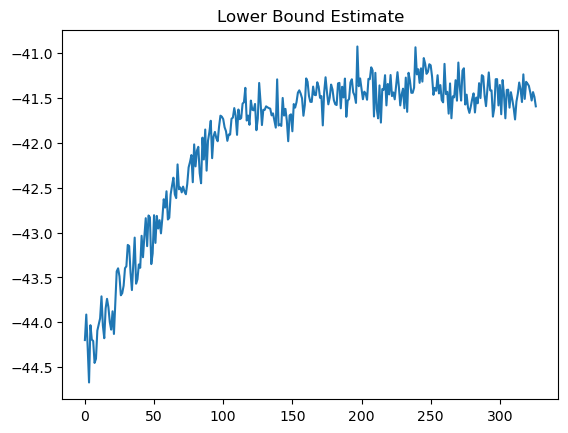

In [31]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<Axes: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

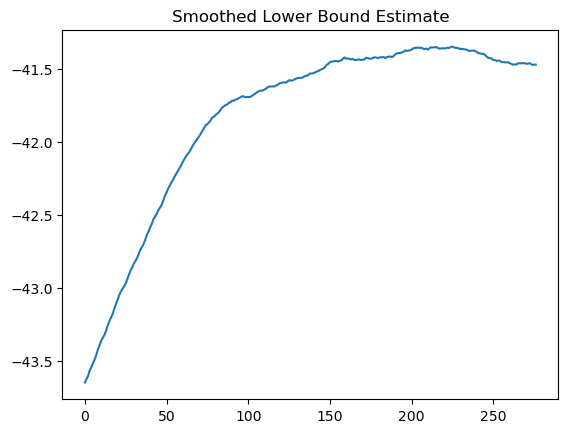

In [30]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [33]:
best_mu = best_lambda[0]
best_vech_l = list(best_lambda[1])
best_l = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l[i:num_coeffs,i] = best_vech_l[:num_coeffs - i]
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 100000)
best_alpha = (2 * np.exp(best_theta_tilde[:,0]) + 1) / (1 + np.exp(best_theta_tilde[:,0]))
best_beta = (100 * np.exp(best_theta_tilde[:,1]) + 0) / (np.exp(best_theta_tilde[:,1]) + 1)
best_gamma = (0.9 * np.exp(best_theta_tilde[:,2]) + 0) / (np.exp(best_theta_tilde[:,2]) + 1)
best_theta = np.array([best_alpha, best_beta, best_gamma])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([ 1.67361823, 37.07922643,  0.65440538])

In [34]:
np.linalg.norm(posterior_mean_estimate - true_theta)

2.0801054074806573

In [1]:
# best_mu_untransformed = best_lambda_untransformed[0]
# best_vech_l_untransformed = list(best_lambda_untransformed[1])
# best_l_untransformed = np.zeros((num_coeffs, num_coeffs))
# for i in range(num_coeffs):
#     best_l_untransformed[i:num_coeffs,i] = best_vech_l_untransformed[:num_coeffs - i]
#     del best_vech_l_untransformed[:num_coeffs-i]
# best_Sigma_untransformed =  np.linalg.inv(best_l_untransformed @ best_l_untransformed.T)

# best_theta_tilde_untransformed = multivariate_normal.rvs(mean = best_mu_untransformed, cov = best_Sigma_untransformed, size = 1000)
# best_alpha_untransformed = (2 * np.exp(best_theta_tilde_untransformed[:,0]) + 1.1) / (1 + np.exp(best_theta_tilde_untransformed[:,0]))
# best_beta_untransformed = (np.exp(best_theta_tilde_untransformed[:,1]) - 1) / (np.exp(best_theta_tilde_untransformed[:,1]) + 1)
# best_gamma_untransformed = np.exp(best_theta_tilde_untransformed[:,2])
# best_delta_untransformed = best_theta_tilde_untransformed[:,3]
# best_theta_untransformed = np.array([best_alpha_untransformed, best_beta_untransformed, best_gamma_untransformed, best_delta_untransformed])
# posterior_mean_estimate_untransformed = np.mean(best_theta_untransformed, axis = 1)
# posterior_mean_estimate_untransformed

In [4]:
# best_mu_wass = best_lambda_wass[0]
# best_vech_l_wass = list(best_lambda_wass[1])
# best_l_wass = np.zeros((num_coeffs, num_coeffs))
# for i in range(num_coeffs):
#     best_l_wass[i:num_coeffs,i] = best_vech_l_wass[:num_coeffs - i]
#     del best_vech_l_wass[:num_coeffs-i]
# best_Sigma_wass =  np.linalg.inv(best_l_wass @ best_l_wass.T)

# best_theta_tilde_wass = multivariate_normal.rvs(mean = best_mu_wass, cov = best_Sigma_wass, size = 1000)
# best_alpha_wass = (2 * np.exp(best_theta_tilde_wass[:,0]) + 1.1) / (1 + np.exp(best_theta_tilde_wass[:,0]))
# best_beta_wass = (np.exp(best_theta_tilde_wass[:,1]) - 1) / (np.exp(best_theta_tilde_wass[:,1]) + 1)
# best_gamma_wass = np.exp(best_theta_tilde_wass[:,2])
# best_delta_wass = best_theta_tilde_wass[:,3]
# best_theta_wass = np.array([best_alpha_wass, best_beta_wass, best_gamma_wass, best_delta_wass])
# posterior_mean_estimate_wass = np.mean(best_theta_wass, axis = 1)
# posterior_mean_estimate_wass

Text(0.5, 1.0, 'Posterior density of alpha')

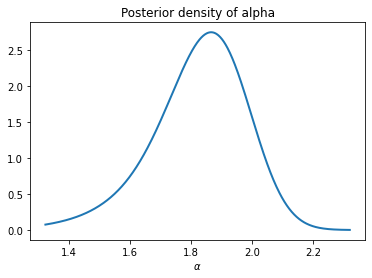

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(best_alpha.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

In [ ]:
# plt.figure()
# #x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
# x_plot = np.arange(min(np.mean(best_alpha_untransformed)-4*np.std(best_alpha_untransformed),np.mean(best_alpha)-4*np.std(best_alpha)), max(np.mean(best_alpha_untransformed)+4*np.std(best_alpha_untransformed), np.mean(best_alpha)+4*np.std(best_alpha)), 0.001)

# kde_vb = KernelDensity(bandwidth=0.0055, kernel='gaussian')
# kde_vb.fit(best_alpha.reshape(-1, 1))
# y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

# #x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
# kde_vb_untransformed = KernelDensity(bandwidth=0.01, kernel='gaussian')
# kde_vb_untransformed.fit(best_alpha_untransformed.reshape(-1, 1))
# y_plot_vb_untransformed = kde_vb_untransformed.score_samples(x_plot.reshape(-1, 1))

# kde_vb_wass = KernelDensity(bandwidth=0.01, kernel='gaussian')
# kde_vb_wass.fit(best_alpha_wass.reshape(-1, 1))
# y_plot_vb_wass = kde_vb_wass.score_samples(x_plot.reshape(-1, 1))

# plt.plot(x_plot, np.exp(y_plot_vb_untransformed), '-', linewidth=2.0, label = 'VB - BSL')
# plt.plot(x_plot, np.exp(y_plot_vb_wass), '-', linewidth=2.0, label = 'WG - VB - BSL')
# plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL')
# # only one line may be specified; full height
# plt.axvline(x = 1.5, ymin = 0, ymax = max(y_plot_vb_untransformed), color = 'black', label = 'True alpha')

# plt.legend()
# plt.xlabel(r'$\alpha$')
# plt.title('Posterior density of alpha')


Text(0.5, 1.0, 'Posterior density of beta')

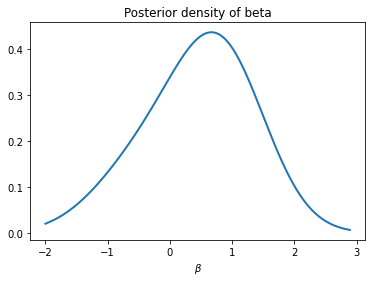

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_beta)-4*np.std(best_beta)), (np.mean(best_beta)+4*np.std(best_beta)), 0.002)
kde = KernelDensity(bandwidth=0.7, kernel='gaussian')
kde.fit(best_beta.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

Text(0.5, 1.0, 'Posterior density of gamma')

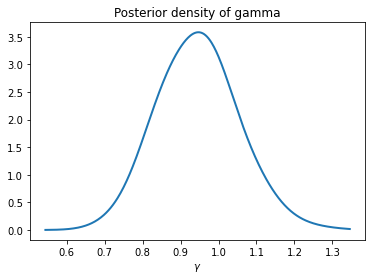

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_gamma)-4*np.std(best_gamma)), (np.mean(best_gamma)+4*np.std(best_gamma)), 0.002)
kde = KernelDensity(bandwidth=0.05, kernel='gaussian')
kde.fit(best_gamma.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

## VBSL-WG

In [ ]:
def prior(theta): 
    log_prior = np.sum(np.log(np.exp(theta) / (1 + np.exp(theta))**2))
    return log_prior

In [ ]:
def summary_statistics(theta, n_samples, n_datasets, mixture_obj_seq):
    datasets = toad(theta[0], theta[1], theta[2],batch_size=n_datasets)
    n_summary_statistics = np.array([compute_summaries_stacked(datasets[:,:,i], lags)[0] for i in range(n_datasets)])
    # Wasserstein transform
    transformed_summary_statistics = wasserstein_transform(mixture_obj_seq, n_summary_statistics)

    sample_mean = np.mean(transformed_summary_statistics, axis = 0)
    sample_variance = np.cov(np.array(transformed_summary_statistics).T)
    return sample_mean, sample_variance

def unbiased_log_likelihood(theta, actual_summary_statistics):
    ss = summary_statistics(theta, n_samples, num_datasets, mixture_obj_seq)
    sample_mean = ss[0]
    sample_variance = ss[1]
    diff_mean_s = actual_summary_statistics - sample_mean
    part1 = diff_mean_s.T @ np.linalg.inv(sample_variance) @ diff_mean_s
    # u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - (self.num_datasets - self.num_coeffs - 2) / (2 * (self.num_datasets-1)) * part1
    u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - part1
    return u_est_log_likelihood

In [ ]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 200 # number of datasets
        self.num_coeffs = 3 # number of coeffs
        self.lambda_dim = self.num_coeffs + int((self.num_coeffs * (self.num_coeffs + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def log_q(self, theta, mu, l):
        log_q = multivariate_normal.logpdf(theta, mean = mu, cov= np.linalg.inv(l @ l.T))
        return log_q

    def gradient_log_q(self, theta, mu, l): #indep theta
        gradient_log_q_mu = np.matmul(np.matmul(l, l.T), (theta - mu))
        diag_inv_l = np.zeros((num_coeffs, num_coeffs))
        np.fill_diagonal(diag_inv_l, np.diag(np.linalg.inv(l)))
        gradient_log_q_l = (diag_inv_l - np.reshape(theta - mu, (num_coeffs,1)) @ np.reshape(theta - mu, (1,num_coeffs)) @ l).T[np.triu_indices(num_coeffs)] #use * because matmul gives scalar 
        gradient_log_q = np.array([gradient_log_q_mu, gradient_log_q_l], dtype=object)
        return gradient_log_q

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:self.num_coeffs])
        c_vech_l = np.array(c[self.num_coeffs:])
        return np.array([c_mu, c_vech_l], dtype = object)

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        # mu_0 = np.array([np.log((true_theta[0] - 1)/(2 - true_theta[0])),np.log((true_theta[1] - 0)/(100 - true_theta[1])),np.log((true_theta[2] - 0)/(0.9 - true_theta[2]))])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        mu_0 = np.array([0] * self.num_coeffs)
        # l_0 = np.array([[ 3.94992238, -2.12969451,  0.47239626],
        #                 [-2.12969451, 21.85908684, -1.45228054],
        #                 [ 0.47239626, -1.45228054, 15.84326737]])
        l_0 = np.tril(np.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = np.linalg.inv(Sigma_0_inv)
        l_0_inv = np.linalg.inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices(self.num_coeffs)]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []
        for t in tqdm(range(stop)):
            if t == 0:        
                # Draw samples of theta from  variational q
                # List of gradients
                Gradient_lb_init = []
                lb_0 = []
                theta_0_samples = multivariate_normal.rvs(mean = mu_0, cov = Sigma_0, size = self.samples)
                for s in tqdm(range(self.samples)):
                    # True params have been reparam into epsilon
                    theta_tilde_0 = theta_0_samples[s]
                    alpha_0 = (2 * np.exp(theta_tilde_0[0]) + 1) / (1 + np.exp(theta_tilde_0[0]))
                    beta_0 = (100 * np.exp(theta_tilde_0[1]) + 0) / (1 + np.exp(theta_tilde_0[1]))
                    gamma_0 = (0.9 * np.exp(theta_tilde_0[2]) + 0) / (1 + np.exp(theta_tilde_0[2]))
                    theta_0 = np.array([alpha_0, beta_0, gamma_0])
                    
                    # Find gradient of LB
                    h_lambda_init = prior(theta_tilde_0) + unbiased_log_likelihood(theta_0, self.actual_summary_statistics) - self.log_q(theta_tilde_0, mu_0, l_0)
                    gradient_lb_init = self.gradient_log_q(theta_tilde_0, mu_0, l_0) * (h_lambda_init)
                    Gradient_lb_init.append(gradient_lb_init)
                    # Calculate control variates
                    flattened_gradient_log_q = np.concatenate((self.gradient_log_q(theta_tilde_0, mu_0, l_0)[0], self.gradient_log_q(theta_tilde_0, mu_0, l_0)[1]), axis = None)
                    Flattened_gradient_log_q.append(flattened_gradient_log_q)
                    flattened_gradient_lb = np.concatenate((gradient_lb_init[0], gradient_lb_init[1]), axis = None)
                    Flattened_gradient_lb.append(flattened_gradient_lb)
                    # Calculate lower bound
                    lb_0.append(h_lambda_init)
                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb_init, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(lb_0))
                print('LB', (np.mean(lb_0)))
                lambda_q = lambda_0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q[1])
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q[i:self.num_coeffs,i] = vech_lq[:self.num_coeffs - i]
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  np.linalg.inv(Sigma_q_inv)
                l_q_inv =  np.linalg.inv(l_q)
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = multivariate_normal.rvs(mean = mu_q, cov = Sigma_q, size = self.samples)
                for s in range(self.samples):
                    theta_tilde_q = theta_q_samples[s]
                    # Calculate theta from mu, l (lambda)
                    alpha_q = (2 * np.exp(theta_tilde_q[0]) + 1) / (1 + np.exp(theta_tilde_q[0]))
                    beta_q = (100 * np.exp(theta_tilde_q[1]) + 0) / (1 + np.exp(theta_tilde_q[1]))
                    gamma_q = (0.9 * np.exp(theta_tilde_q[2]) + 0) / (1 + np.exp(theta_tilde_q[2]))
                    theta_q = np.array([alpha_q, beta_q, gamma_q])
                    
                    # Find gradient of LB
                    h_lambda = prior(theta_tilde_q) + unbiased_log_likelihood(theta_q, self.actual_summary_statistics) - self.log_q(theta_tilde_q, mu_q, l_q)
                    # Find gradient of LB
                    gradient_lb = self.gradient_log_q(theta_tilde_q, mu_q, l_q) * (h_lambda - c)

                    Gradient_lb.append(gradient_lb)
                    # Calculate control variates
                    Flattened_gradient_log_q[s] = np.concatenate((self.gradient_log_q(theta_tilde_q, mu_q, l_q)[0], self.gradient_log_q(theta_tilde_q, mu_q, l_q)[1]), axis = None)
                    Flattened_gradient_lb[s] = np.concatenate((gradient_lb[0], gradient_lb[1]), axis = None)
                    # Calc lower bound estimate
                    lb_t.append(h_lambda)
                # Update control variates
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(lb_t))

                if t < self.t_w:
                    print('LB', np.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

In [ ]:
nn_vb = GVB(200, transformed_summary_statistics[0], 0.005, 2500, 100, 0.9, 0.9, 50, 50)
nn_LB_estimate, nn_smoothed_LB_estimate, nn_best_lambda = nn_vb.vb_posterior(stop)

NameError: name 'transformed_summary_statistics' is not defined

In [ ]:
nn_best_lambda

array([array([ 0.7346095 , -0.70012037,  0.67198676]),
       array([ 4.36810339, -2.42016574,  0.40744222, 22.2448585 , -1.47434547,
              16.14305194])                                                   ],
      dtype=object)

<AxesSubplot: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

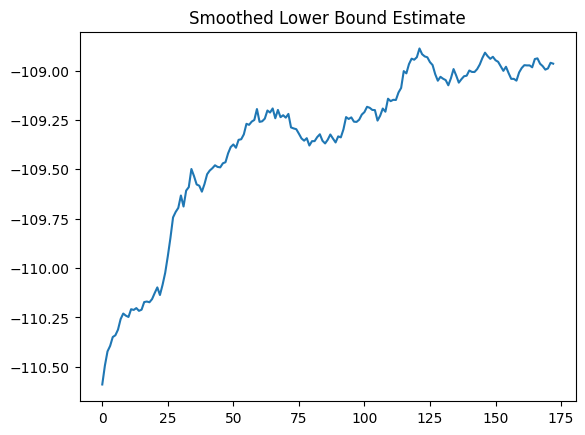

In [ ]:
lb_df = pd.DataFrame(np.array(nn_smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [ ]:
best_mu = nn_best_lambda[0]
best_vech_l = list(nn_best_lambda[1])
best_l = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l[i:num_coeffs,i] = best_vech_l[:num_coeffs - i]
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 1000)
best_alpha = (2 * np.exp(best_theta_tilde[:,0]) + 1) / (1 + np.exp(best_theta_tilde[:,0]))
best_beta = (100 * np.exp(best_theta_tilde[:,1]) + 0) / (1 + np.exp(best_theta_tilde[:,1]))
best_gamma = (0.9 * np.exp(best_theta_tilde[:,2]) + 0) / (1 + np.exp(best_theta_tilde[:,2]))
best_theta = np.array([best_alpha, best_beta, best_gamma])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([ 1.67309654, 33.20753569,  0.59541459])

In [ ]:
# num_samples = 50000
# num_burnin = 0.2 * num_samples

In [ ]:
# def sampler(samples):

# 	# ------------------- initialize MCMC

# 	w_size = num_coeffs  # num of weights and bias

# 	pos_w = np.ones((samples, w_size))  # posterior of all weights and bias over all samples
# 	pos_w_tilde = np.ones((samples, w_size))

# 	w_tilde = np.array([np.log((1.5-1.1)/(2-1.5)),np.log((0.5+1)/(1-0.5)),np.log(1),0])
# 	# w_tilde = [np.log((actual_summary_statistics[0]-1.1)/(2-actual_summary_statistics[0])), np.log((1+actual_summary_statistics[1])/(1-actual_summary_statistics[1])), np.log(actual_summary_statistics[2]), actual_summary_statistics[3]]

# 	alpha = (2 * np.exp(w_tilde[0]) + 1.1) / (1 + np.exp(w_tilde[0]))
# 	beta = (np.exp(w_tilde[1]) - 1) / (np.exp(w_tilde[1]) + 1)
# 	gamma = np.exp(w_tilde[2])
# 	delta = w_tilde[3]
# 	w = np.array([alpha, beta, gamma, delta])

# 	# GENERATE GAMMA
# 	Gamma_init = np.random.exponential(scale = 0.5, size = (gamma_samples, num_latent))
# 	adjusted_w = np.concatenate((np.tile(w, (gamma_samples, 1)), Gamma_init), axis = 1)
# 	# --------------------- 

# 	prior_current = prior(w_tilde)  # takes care of the gradients

# 	likelihood_current = variance_adjustment_unbiased_log_likelihood(adjusted_w)

# 	naccept = 0
		
# 	for i in range(samples - 1):
# 		if i < 2000:
# 			w_proposal_tilde = multivariate_normal.rvs(mean = w_tilde, cov = ((0.1**2/w_size) * np.identity(w_size)))
# 		else:
# 			if i % 500 == 0:
# 				Sign = np.cov(pos_w_tilde[0:i, :].T)
# 			u_proposal = random.uniform(0, 1)
# 			if u_proposal < 0.05:
# 				w_proposal_tilde = multivariate_normal.rvs(mean = w_tilde, cov = ((0.1**2/w_size) * np.identity(w_size)))
# 			else:
# 				w_proposal_tilde = multivariate_normal.rvs(mean = w_tilde, cov = (2.38**2/w_size) * Sign)

# 		alpha_prop = (2 * np.exp(w_proposal_tilde[0]) + 1.1) / (1 + np.exp(w_proposal_tilde[0]))
# 		beta_prop = (np.exp(w_proposal_tilde[1]) - 1) / (np.exp(w_proposal_tilde[1]) + 1)
# 		gamma_prop = np.exp(w_proposal_tilde[2])
# 		delta_prop = w_proposal_tilde[3]
# 		w_proposal = np.array([alpha_prop, beta_prop, gamma_prop, delta_prop])

# 		# GENERATE GAMMA
# 		Gamma = np.random.exponential(scale = 0.5, size = (gamma_samples, num_latent))
# 		adjusted_w_proposal = np.concatenate((np.tile(w_proposal, (gamma_samples, 1)), Gamma), axis = 1)
# 		# --------------------- 

# 		prior_proposal = prior(w_proposal_tilde)  # takes care of the gradients
# 		likelihood_proposal = variance_adjustment_unbiased_log_likelihood(adjusted_w_proposal)

# 		diff_prior = prior_proposal - prior_current

# 		diff_likelihood = likelihood_proposal - likelihood_current

# 		try:
# 			mh_prob = min(1, math.exp(diff_likelihood+diff_prior))

# 		except OverflowError as e:
# 			mh_prob = 1


# 		u = random.uniform(0, 1)

# 		if u < mh_prob:
# 			# Update position 
# 			naccept += 1
# 			likelihood_current = likelihood_proposal
# 			prior_current = prior_proposal
# 			w_tilde = w_proposal_tilde
# 			w = w_proposal
# 			pos_w_tilde[i + 1,] = w_proposal_tilde	
# 			pos_w[i + 1,] = w_proposal
# 			print(i, pos_w[i + 1,])

# 		else:
# 			pos_w_tilde[i + 1,] = pos_w_tilde[i,]
# 			pos_w[i + 1,] = pos_w[i,]

# 	print(naccept, ' num accepted')
# 	print(naccept / (samples * 1.0) * 100, '% was accepted')
# 	accept_ratio = naccept / (samples * 1.0) * 100

# 	return (pos_w, pos_w_tilde, accept_ratio)

In [ ]:
# pos_w, pos_w_tilde, accept_ratio = sampler(num_samples)

In [ ]:
# pos_w = np.loadtxt('mcmc_w_varobust.txt')
# pos_w_tilde = np.loadtxt('mcmc_w_tilde_varobust.txt')

In [ ]:
# plt.figure()
# pos_alpha_mean = np.mean(pos_w[int(num_burnin):,0])
# pos_alpha_std = np.std(pos_w[int(num_burnin):,0])
# x_plot = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.001)
# kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
# kde.fit(pos_w[int(num_burnin):,0].reshape(-1, 1))
# y_plot = kde.score_samples(x_plot.reshape(-1, 1))
# plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
# plt.xlabel(r'$\alpha$')
# plt.title('Posterior density of alpha')

In [ ]:
# plt.figure()
# pos_alpha_mean = np.mean(pos_w[int(num_burnin):,0])
# pos_alpha_std = np.std(pos_w[int(num_burnin):,0])
# #x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
# x_plot = np.arange(min(pos_alpha_mean-4*pos_alpha_std,np.mean(best_alpha)-4*np.std(best_alpha)), max(pos_alpha_mean+4*pos_alpha_std, np.mean(best_alpha)+4*np.std(best_alpha)), 0.001)
# kde_mcmc = KernelDensity(bandwidth=0.075, kernel='gaussian')
# kde_mcmc.fit(pos_w[int(num_burnin):,0].reshape(-1, 1))
# y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

# #x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
# kde_vb = KernelDensity(bandwidth=0.155, kernel='gaussian')
# kde_vb.fit(best_alpha.reshape(-1, 1))
# y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

# plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC')
# plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB')

# plt.legend()
# plt.xlabel(r'$\alpha$')
# plt.title('Posterior density of alpha')


In [ ]:
# plt.figure()

# pos_beta_mean = np.mean(pos_w[int(num_burnin):,1])
# pos_beta_std = np.std(pos_w[int(num_burnin):,1])
# x_plot = np.arange((pos_beta_mean-4*pos_beta_std), (pos_beta_mean+4*pos_beta_std), 0.001)
# kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
# kde.fit(pos_w[int(num_burnin):,1].reshape(-1, 1))
# y_plot = kde.score_samples(x_plot.reshape(-1, 1))
# plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
# plt.xlabel(r'$\beta$')
# plt.title('Posterior density of beta')

In [ ]:
# plt.figure()
# pos_beta_mean = np.mean(pos_w[int(num_burnin):,1])
# pos_beta_std = np.std(pos_w[int(num_burnin):,1])
# #x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
# x_plot = np.arange(min(pos_beta_mean-4*pos_beta_std,np.mean(best_beta)-4*np.std(best_beta)), max(pos_beta_mean+4*pos_beta_std, np.mean(best_beta)+4*np.std(best_beta)), 0.001)
# kde_mcmc = KernelDensity(bandwidth=0.1, kernel='gaussian')
# kde_mcmc.fit(pos_w[int(num_burnin):,1].reshape(-1, 1))
# y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

# #x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
# kde_vb = KernelDensity(bandwidth=0.35, kernel='gaussian')
# kde_vb.fit(best_beta.reshape(-1, 1))
# y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

# plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC')
# plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB')

# plt.legend()
# plt.xlabel(r'$\beta$')
# plt.title('Posterior density of beta')


In [ ]:
# plt.figure()

# pos_gamma_mean = np.mean(pos_w[int(num_burnin):,2])
# pos_gamma_std = np.std(pos_w[int(num_burnin):,2])
# x_plot = np.arange((pos_gamma_mean-4*pos_gamma_std), (pos_gamma_mean+4*pos_gamma_std), 0.002)
# kde = KernelDensity(bandwidth=0.02, kernel='gaussian')
# kde.fit(pos_w[int(num_burnin):,2].reshape(-1, 1))
# y_plot = kde.score_samples(x_plot.reshape(-1, 1))
# plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
# plt.xlabel(r'$\gamma$')
# plt.title('Posterior density of gamma')

In [ ]:
# plt.figure()
# pos_gamma_mean = np.mean(pos_w[int(num_burnin):,2])
# pos_gamma_std = np.std(pos_w[int(num_burnin):,2])
# #x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
# x_plot = np.arange(min(pos_gamma_mean-4*pos_gamma_std,np.mean(best_gamma)-4*np.std(best_gamma)), max(pos_gamma_mean+4*pos_gamma_std, np.mean(best_gamma)+4*np.std(best_gamma)), 0.001)
# kde_mcmc = KernelDensity(bandwidth=0.0375, kernel='gaussian')
# kde_mcmc.fit(pos_w[int(num_burnin):,2].reshape(-1, 1))
# y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

# #x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
# kde_vb = KernelDensity(bandwidth=0.025, kernel='gaussian')
# kde_vb.fit(best_gamma.reshape(-1, 1))
# y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

# plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC')
# plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB')

# plt.legend()
# plt.xlabel(r'$\gamma$')
# plt.title('Posterior density of gamma')


In [ ]:
# alpha_trace = pos_w[int(num_burnin):,0]
# beta_trace = pos_w[int(num_burnin):,1]
# gamma_trace = pos_w[int(num_burnin):,2]
# delta_trace = pos_w[int(num_burnin):,3]

# x = np.arange(len(alpha_trace))
# plt.figure(facecolor = 'white')
# plt.plot(x, alpha_trace, label='Alpha')  
# plt.plot(x, beta_trace, label='Beta')  
# plt.plot(x, gamma_trace, label='Gamma')  
# plt.xlabel('Number of samples')
# plt.ylabel('Theta')
# plt.legend()
# plt.title("Trace Plot for Theta")
# plt.show()